In [1]:
import math
from typing import Any

import torch

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto
from torch.nn import init
seed=0
#torch.cuda.manual_seed_all(seed)
#with torch.cuda.device('cuda:0'):
 #   torch.cuda.empty_cache()
inputs=torch.rand(784,784)
mean=1
#rates = torch.ones_like(inputs) * lambdas  # rate parameter between 0 and 5
#print(rates)
#outputs=torch.poisson(rates)
def stats(tensor):
    # Calculate the mean
    mean = torch.mean(tensor)
    # Calculate the variance
    second = torch.mean(torch.pow(tensor,2))
    third = torch.mean(torch.pow(tensor,3))
    fourth=torch.mean(torch.pow(tensor,4))
    # Calculate the standard deviation
    var=torch.var(tensor)
    std = torch.sqrt(var)
    # Calculate the z-scores
    zscores = (tensor - mean) / std
    # Calculate the skewness
    skew = torch.mean(zscores ** 3)
    # Calculate the kurtosis
    kurt = torch.mean(zscores ** 4) - 3
    #Return the results as a tuple
    return mean, var, skew, kurt
#mean, second, skew, kurt=stats(outputs)
#print(mean, second, skew, kurt)

doing
tensor(2401.4912) tensor(847023.1250) tensor(-0.0069) tensor(-1.2022)


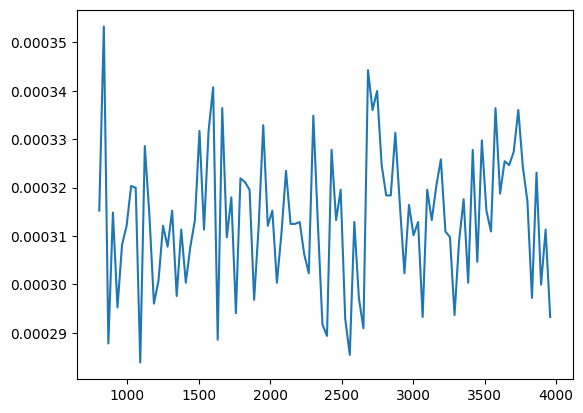

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial
ep=0
delta=1
import torch
from torch.distributions.gamma import Gamma
def likelihood(ep,delta,x):
    #l is the lambda/mean
    #k is a random variable drawing from a uniform sampling of variables from a given range
    
    # Standard Normal Distribution
    # An underlying assumption of linear regression is that the residuals
    # are Gaussian Normal Distributed; often, Standard Normal distributed
    return np.sinh(ep+delta*np.arcsinh(x))
def proposal_distribution(x, stepsize=0.1):
    # Select the proposed state (new guess) from a Gaussian distribution
    #  centered at the current state, within a Guassian of width `stepsize`
    return np.random.normal(x, stepsize)
def mcmc_updater(curr_state, curr_likeli, 
      likelihood, proposal_distribution,ep,delta):
    """ Propose a new state and compare the likelihoods
    
    Given the current state (initially random), 
      current likelihood, the likelihood function, and 
      the transition (proposal) distribution, `mcmc_updater` generates 
      a new proposal, evaluate its likelihood, compares that to the current 
      likelihood with a uniformly samples threshold, 
    then it returns new or current state in the MCMC chain.

    Args:
        curr_state (float): the current parameter/state value
        curr_likeli (float): the current likelihood estimate
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state

    Returns:
        (tuple): either the current state or the new state
          and its corresponding likelihood
    """
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = proposal_distribution(curr_state)

    # Calculate the acceptance criterion
    prop_likeli = likelihood(ep,delta,proposal_state)
    #if prop_likeli<0:
     #   prop_likeli=0
    #print(prop_likeli)
    accept_crit = prop_likeli / curr_likeli

    # Generate a random number between 0 and 1
    accept_threshold = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if prop_likeli>curr_likeli:
        return proposal_state, prop_likeli

    # Else
    return curr_state, curr_likeli

def metropolis_hastings(
        likelihood, proposal_distribution, initial_state, 
        num_samples, ep,delta,stepsize=0.5, burnin=0.2):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []

    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(ep,delta,curr_state)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_likeli = mcmc_updater(curr_state, curr_likeli, 
      likelihood, proposal_distribution,ep,delta)
    

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            samples.append(curr_state)

    return samples
np.random.seed(42)
print("doing")
initial_state = 0.1  # Trivial case, starting at the mode of the likelihood
num_samples = int(1e5)
burnin = 0.2
mean=0.01
x=np.arange(num_samples*burnin,num_samples)
a=metropolis_hastings( likelihood, proposal_distribution, initial_state, 
        num_samples,ep,delta)
counts, bins =np.histogram(a, bins=100, density=True)
plt.plot(bins[:-1],counts)
#plt.stairs(counts, bins)
mean, second, skew, kurt=stats(torch.Tensor(a))
print(mean, second, skew, kurt)

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


80000
0.0
tensor(0.0003) tensor(0.2998) tensor(0.0059) tensor(0.3011)


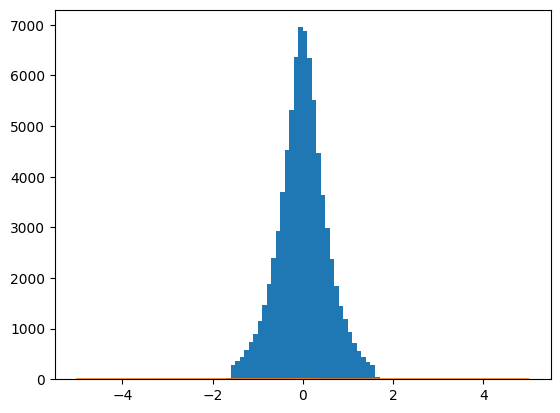

In [3]:
from numpy import random
#from scipy.spe
eta=1
delta=0.5
def normal(x,mu,sigma,z):
    numerator = np.exp((-(x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True
zscore=5    
def gaussian_mcmc(hops,mu,sigma):
    states = []
    burn_in = int(hops*0.2)
    current = random.uniform(-zscore*sigma+mu,zscore*sigma+mu)
    for i in range(hops):
        states.append(current)
        z=current
        movement = random.uniform(-zscore*sigma+mu,zscore*sigma+mu)
        current=eta*np.arctanh((np.tanh(current))/delta)
        movement=eta*np.arctanh((np.tanh(movement))/delta)
        curr_prob = normal(x=current,mu=mu,sigma=sigma,z=z)
        #print(curr_prob,current)
        move_prob = normal(x=movement,mu=mu,sigma=sigma,z=z)
        
        acceptance = min(move_prob/curr_prob,1)
        if random_coin(acceptance):
            current = movement
    return states[burn_in:]
    
lines = np.linspace(-5,5,1000)
normal_curve = [normal(l,mu=0,sigma=0.1,z=0) for l in lines]
dist = gaussian_mcmc(100000,mu=0,sigma=0.1)
print(len(dist))
count=0
for i in range(len(dist)):
    if np.abs(dist[i])>10**9:
        #print(dist[i])
        count+=1
print(count/100000)
plt.hist(dist,bins=100,range=(-5,5)) 
plt.plot(lines,normal_curve)
mean, second, skew, kurt=stats(torch.Tensor(dist))
print(mean, second, skew, kurt)

In [4]:
weight_tuning=1
oneover=2
lambdas=1/oneover
b=0.8
## initial =1
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #if reset=True:
            
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        #init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        bound =weight_tuning/ math.sqrt(fan_in)
        #torch.Tensor(gamma.sample())
        #init.uniform_(self.weight, -bound,bound)
        print(self.weight.size)
        #a=gamma.rvs(b, size=self.in_features*self.out_features)
        #print(a)
        #a.resize((self.out_features,self.in_features))
        print(int(np.floor(self.in_features*self.out_features/(1-0.25))))
        a=np.asarray(gaussian_mcmc(int(np.floor(self.in_features*self.out_features/(1-0.25))),mu=0,sigma=0.1))
        print(np.floor(self.in_features*self.out_features/(1-0.25))*0.80-self.in_features*self.out_features)
        a=a[:self.out_features*self.in_features]
        a=np.resize(a,(self.out_features,self.in_features))
        #a[:self.out_features*self.in_features].resize((self.out_features,self.in_features))
        print(a)
        self.weight=torch.nn.Parameter(torch.Tensor(a))
        #bound =weight_tuning/ math.sqrt(fan_in)
        
        #weights=torch.ones_like(self.weight)*lambdas
        #self.weight=torch.nn.Parameter(torch.poisson(weights))
        print(stats(self.weight))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
            #init.uniform_(self.weight, -bound,bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [5]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2



font = {
        'size'   : 26}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        ,bias=False)
        self.hidden_layer=Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        ,bias=False)
        self.encoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        ,bias=False)
        self.decoder_input_layer = Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        ,bias=False)
        self.decoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        ,bias=False)
        #self.encoder_input_layer.weight=torch.nn.Parameter(torch.rand(self.encoder_input_layer.weight.size))
        
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.tanh(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.tanh(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.tanh(code)
        return code
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.tanh(activation)
        for i in range(self.number_of_layers):
             x=torch.tanh(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.tanh(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [6]:

#transform=
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

#print(model.encoder_input_layer.weight)

cuda
<built-in method size of Parameter object at 0x7f8724205990>
819541


/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.93713269  0.65940101  0.66807064 ...  0.20368032  0.42581673
  -1.11893528]
 [ 0.58239063 -0.27289669  0.41465674 ...  0.86755407 -1.01729459
   0.29368665]
 [ 0.64907796 -1.39301674  0.49141225 ... -0.91806639 -0.43269786
   0.32331286]
 ...
 [-0.00514405 -0.01028837 -0.02057892 ... -0.33820241 -0.78641867
  -0.82090299]
 [-0.27981185 -0.12890531 -0.26224278 ...  0.17330585  0.35769571
   0.37606937]
 [ 0.90469894  0.1387742   0.28310926 ...  0.36431686  0.86343165
   0.03113744]]
(tensor(-0.0001, grad_fn=<MeanBackward0>), tensor(0.2979, grad_fn=<VarBackward0>), tensor(0.0033, grad_fn=<MeanBackward0>), tensor(0.3356, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8724205620>
819541
40976.80000000005
[[ 0.22465064 -0.41023477 -1.00811665 ...  0.33262887 -0.51002943
  -0.04742265]
 [-0.09505956 -0.19186883 -0.39900474 ... -1.08174257  0.07715403
   0.1552377 ]
 [ 0.31834002  0.71855005  0.4494722  ... -0.05469935 -0.10972799
  -0.2221637

In [8]:
import matplotlib.pyplot as plt 
epochs=1000
asymptotic_repetition=150


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=20,50
spectral_calculation=5
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3)
interval=50

In [9]:
def add_gaussian_noise(inputs,strength):
    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result
def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])

    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1:
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
   # ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_new,y_pred_unperturbed,no_of_images,no_of_repetition)
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        #diff=0
        diff=torch.ones(1,device=device)
        temp=0
        #print(len(cutoff))
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
            if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                result=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            if result.cpu().detach().numpy()<2**-52:
                result=torch.Tensor([2**-52]).to(device)
            #temp=result
            diff*=result**(1/no_of_image)
            
            #print(j)
            if result>cutoff[j] and i==no_of_repetition-1:
                chaos+=1
        if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
            diff=torch.Tensor([1*10**38]).to(device)
            print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
        if diff.cpu().detach().numpy()<2**-52:
            diff=torch.Tensor([2**-52]).to(device)
        distance.append(diff.cpu().detach().numpy())

    return distance,hidden_layer,chaos/no_of_image

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]



running
<built-in method size of Parameter object at 0x7f840ed775b0>
819541


/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 0.26093542 -0.14598848  0.21747651 ...  0.10955309  0.22180084
   0.46785876]
 [-1.23429668  0.62445274 -0.37383041 ... -0.88458279  0.1609192
   0.15265955]
 [-0.21509302 -0.18729293 -0.38873187 ...  0.41299893  0.39420733
  -0.88592778]
 ...
 [-0.79969967  0.80925087  0.86703269 ... -0.47560616 -1.04588268
   1.03951202]
 [-0.02125027 -0.04251974 -0.15824354 ...  0.62948396  0.15015982
   0.30741392]
 [-0.17951834  0.28374543  0.39966003 ...  0.21231196  0.44569846
   0.72274912]]
(tensor(-0.0004, grad_fn=<MeanBackward0>), tensor(0.2968, grad_fn=<VarBackward0>), tensor(-0.0039, grad_fn=<MeanBackward0>), tensor(0.3383, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8762633b50>
819541
40976.80000000005
[[ 0.03883399  0.07778546  0.15652376 ...  0.98521951  0.72835421
  -1.04956131]
 [-0.69771809 -1.45640151  0.24939302 ... -0.65999709 -0.66212716
   1.24467175]
 [ 1.60659641  0.63480294 -0.90231326 ... -0.38404142  0.15816027
   0.3246541

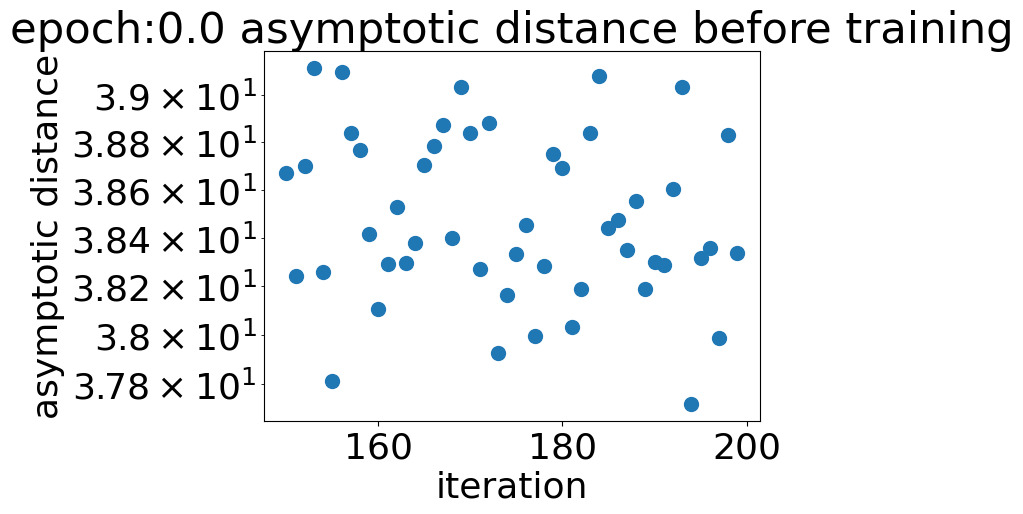

epoch : 1/1000, training loss = 0.690656,validation loss = 0.623579
epoch : 2/1000, training loss = 0.624670,validation loss = 0.624252
epoch : 3/1000, training loss = 0.623789,validation loss = 0.621062
epoch : 4/1000, training loss = 0.623101,validation loss = 0.621048
epoch : 5/1000, training loss = 0.620432,validation loss = 0.616608
epoch : 6/1000, training loss = 0.613711,validation loss = 0.581082
epoch : 7/1000, training loss = 0.391519,validation loss = 0.377884
epoch : 8/1000, training loss = 0.378277,validation loss = 0.376413
epoch : 9/1000, training loss = 0.377812,validation loss = 0.376001
epoch : 10/1000, training loss = 0.377402,validation loss = 0.375908
epoch : 11/1000, training loss = 0.376638,validation loss = 0.374810
epoch : 12/1000, training loss = 0.375690,validation loss = 0.373986
epoch : 13/1000, training loss = 0.374949,validation loss = 0.372890
epoch : 14/1000, training loss = 0.374129,validation loss = 0.372108
epoch : 15/1000, training loss = 0.373535,v

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.03089687 -0.06185285 -0.12418262 ...  0.35756769  0.8406243
  -0.441316  ]
 [-0.24094561 -0.51364127 -0.49366534 ... -0.16096632 -0.12533702
   0.17618952]
 [-0.01050021 -0.02100274 -0.04202402 ...  0.12605822  0.25625505
   0.03454012]
 ...
 [ 0.03062702  0.06131161  0.12308767 ...  0.35516018 -0.23193158
  -0.49189718]
 [ 0.58012869 -1.31654876 -1.50291421 ...  0.02426884  0.0485663
   0.09736279]
 [ 0.19660728 -0.17111595 -0.35288352 ...  0.15463169  0.136254
   0.23244979]]
(tensor(-0.0016, grad_fn=<MeanBackward0>), tensor(0.2985, grad_fn=<VarBackward0>), tensor(0.0019, grad_fn=<MeanBackward0>), tensor(0.3288, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8400f7fba0>
819541
40976.80000000005
[[ 0.21979449  0.46314544  1.31401866 ...  0.19496862  0.40599919
   1.02067356]
 [ 1.59721219 -1.57940001  0.72004226 ... -0.82146366  0.63427218
  -0.01845674]
 [-0.03692606 -0.0739531   0.01140874 ... -0.14812805 -0.12515692
  -0.25436241]
 

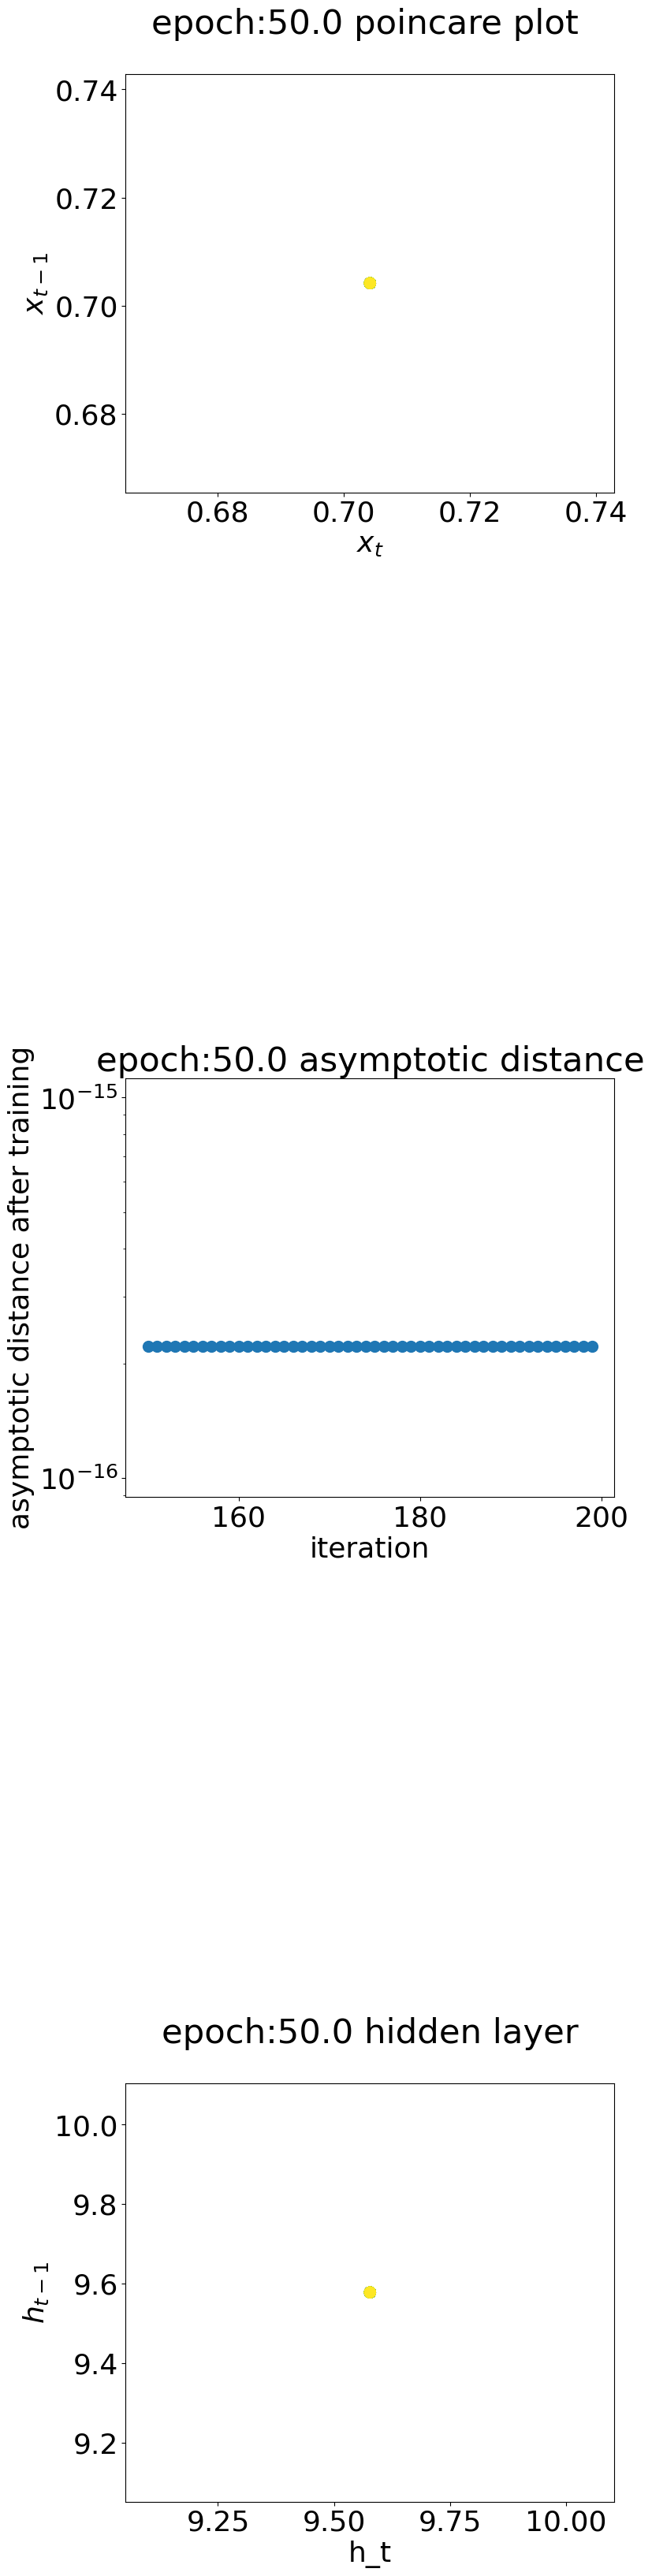

epoch : 51/1000, training loss = 0.374688,validation loss = 0.372882
epoch : 52/1000, training loss = 0.373816,validation loss = 0.372363
epoch : 53/1000, training loss = 0.373799,validation loss = 0.372428
epoch : 54/1000, training loss = 0.373612,validation loss = 0.371368
epoch : 55/1000, training loss = 0.372874,validation loss = 0.372139
epoch : 56/1000, training loss = 0.373514,validation loss = 0.372131
epoch : 57/1000, training loss = 0.373515,validation loss = 0.372129
epoch : 58/1000, training loss = 0.373516,validation loss = 0.372133
epoch : 59/1000, training loss = 0.373516,validation loss = 0.372133
epoch : 60/1000, training loss = 0.373516,validation loss = 0.372128
epoch : 61/1000, training loss = 0.373779,validation loss = 0.372709
epoch : 62/1000, training loss = 0.374069,validation loss = 0.372710
epoch : 63/1000, training loss = 0.374069,validation loss = 0.372711
epoch : 64/1000, training loss = 0.374069,validation loss = 0.372708
epoch : 65/1000, training loss = 0

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 1.00616075 -0.37731464 -0.9013443  ...  0.50683     0.64911146
   0.2457423 ]
 [ 0.29246741  0.09348136  0.1886257  ...  0.69085274 -0.81588869
  -0.29538723]
 [-0.65372354  0.29802307  0.66096435 ...  0.15677073  0.32164969
   0.45415795]
 ...
 [-0.42923826  0.07717036  0.15527097 ...  0.88765491 -0.45855224
   0.34030803]
 [ 0.73628239  0.98689435  0.22795191 ...  0.51653383  0.43531442
   0.47892171]
 [-0.44310949 -0.21939786 -0.46221545 ...  0.17004519  0.35053499
  -0.1553912 ]]
(tensor(-0.0006, grad_fn=<MeanBackward0>), tensor(0.2973, grad_fn=<VarBackward0>), tensor(0.0012, grad_fn=<MeanBackward0>), tensor(0.3392, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840d321030>
819541
40976.80000000005
[[ 1.27972369e+00  5.42815396e-01 -4.40322022e-01 ...  5.90403099e-01
  -1.95740523e-01 -1.42287792e-01]
 [-2.90582136e-01 -1.06143289e-01 -2.14733655e-01 ...  3.08181562e-01
   3.55996730e-01  8.35401993e-01]
 [ 1.98788528e-01 -1.28981151e

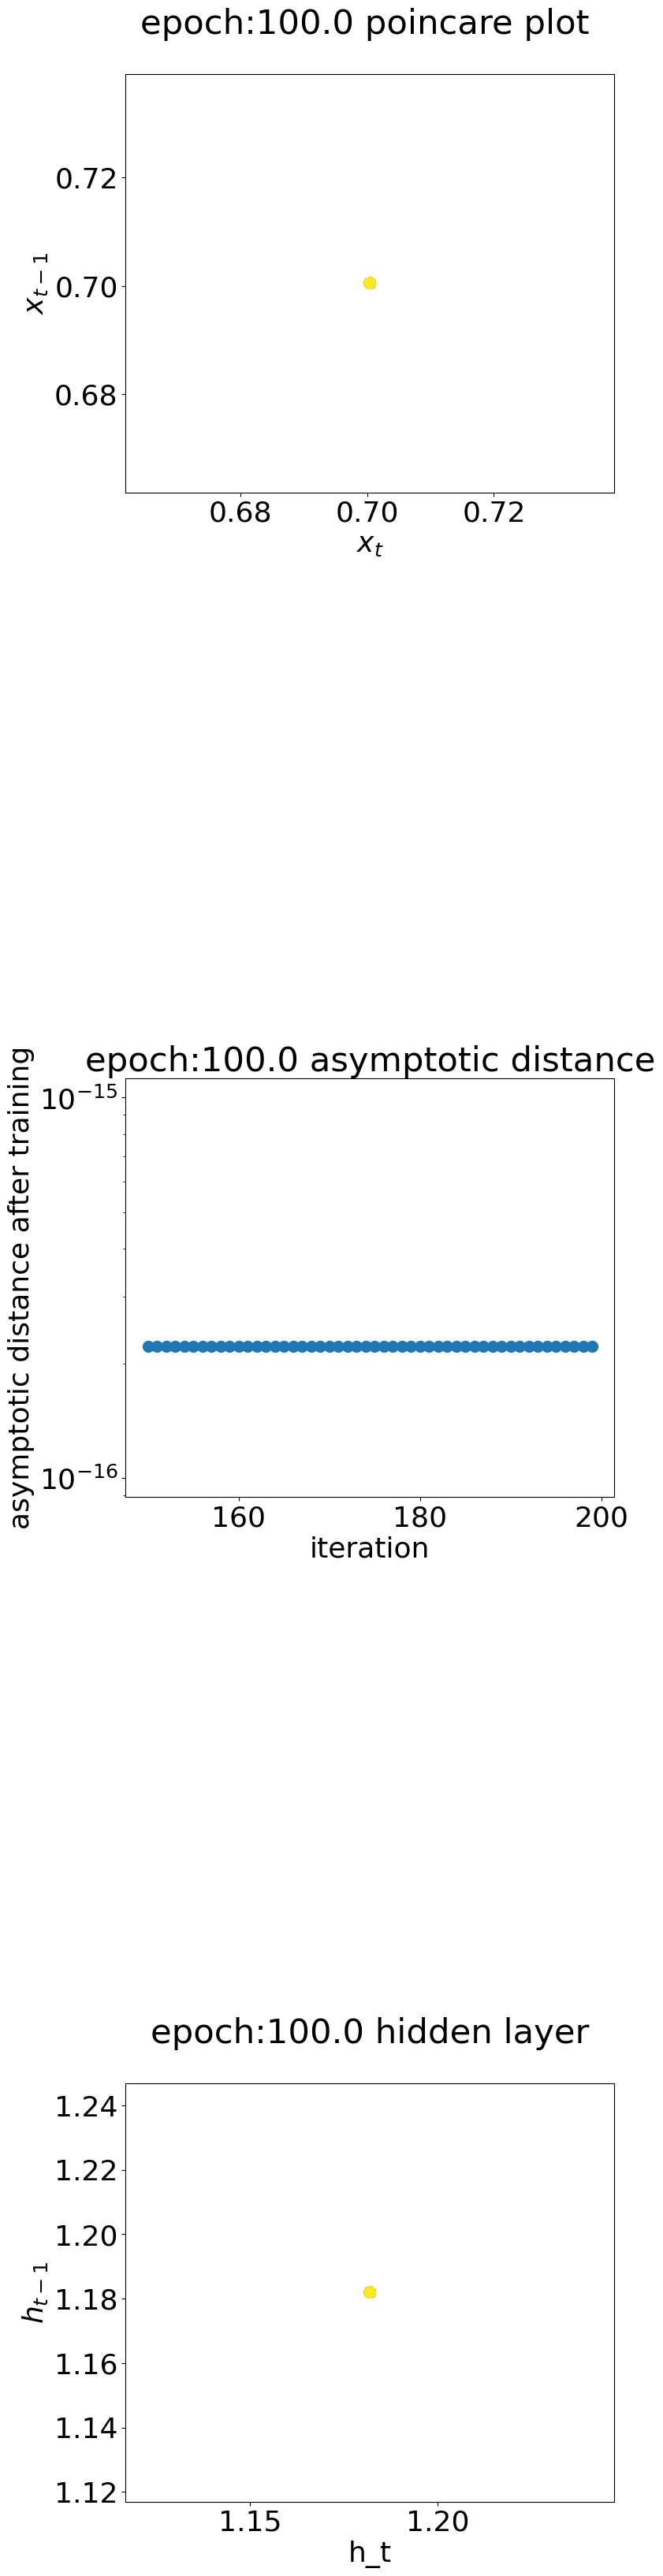

epoch : 101/1000, training loss = 0.373516,validation loss = 0.372128
epoch : 102/1000, training loss = 0.373516,validation loss = 0.372134
epoch : 103/1000, training loss = 0.373516,validation loss = 0.372127
epoch : 104/1000, training loss = 0.373516,validation loss = 0.372127
epoch : 105/1000, training loss = 0.373516,validation loss = 0.372128
epoch : 106/1000, training loss = 0.373516,validation loss = 0.372128
epoch : 107/1000, training loss = 0.373516,validation loss = 0.372126
epoch : 108/1000, training loss = 0.373516,validation loss = 0.372126
epoch : 109/1000, training loss = 0.373530,validation loss = 0.372128
epoch : 110/1000, training loss = 0.376158,validation loss = 0.374513
epoch : 111/1000, training loss = 0.375936,validation loss = 0.374602
epoch : 112/1000, training loss = 0.375999,validation loss = 0.374628
epoch : 113/1000, training loss = 0.376037,validation loss = 0.374669
epoch : 114/1000, training loss = 0.376056,validation loss = 0.374677
epoch : 115/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 0.07734863 -0.03573243 -0.07155635 ...  0.56408068  0.79332835
  -1.06996182]
 [-0.70921548  0.65804879 -1.14314671 ...  0.0499198   0.10008965
   0.14570433]
 [ 0.29787184  0.31158828 -0.09768351 ... -0.81417293  0.08555211
  -0.06258785]
 ...
 [-0.61540551  0.65891108 -1.08828406 ... -0.4851467   0.28513114
   0.62600435]
 [-1.07460307  1.14655964  1.33395893 ...  0.27900262 -0.24163493
   0.19520863]
 [ 0.40654196  1.02294942  0.48853951 ... -0.14455684 -0.29542089
  -0.53350857]]
(tensor(9.2028e-05, grad_fn=<MeanBackward0>), tensor(0.2974, grad_fn=<VarBackward0>), tensor(0.0030, grad_fn=<MeanBackward0>), tensor(0.3334, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8400f9b970>
819541
40976.80000000005
[[ 0.21462425 -0.24052223 -0.18277828 ... -0.74581039  0.12849207
   0.26137282]
 [ 0.56429645  0.0507217   0.0882519  ...  0.68398886  1.07855993
  -0.86455603]
 [ 0.80088684 -1.61601249  0.48147858 ... -0.98931693  0.75253454
  -0.7648

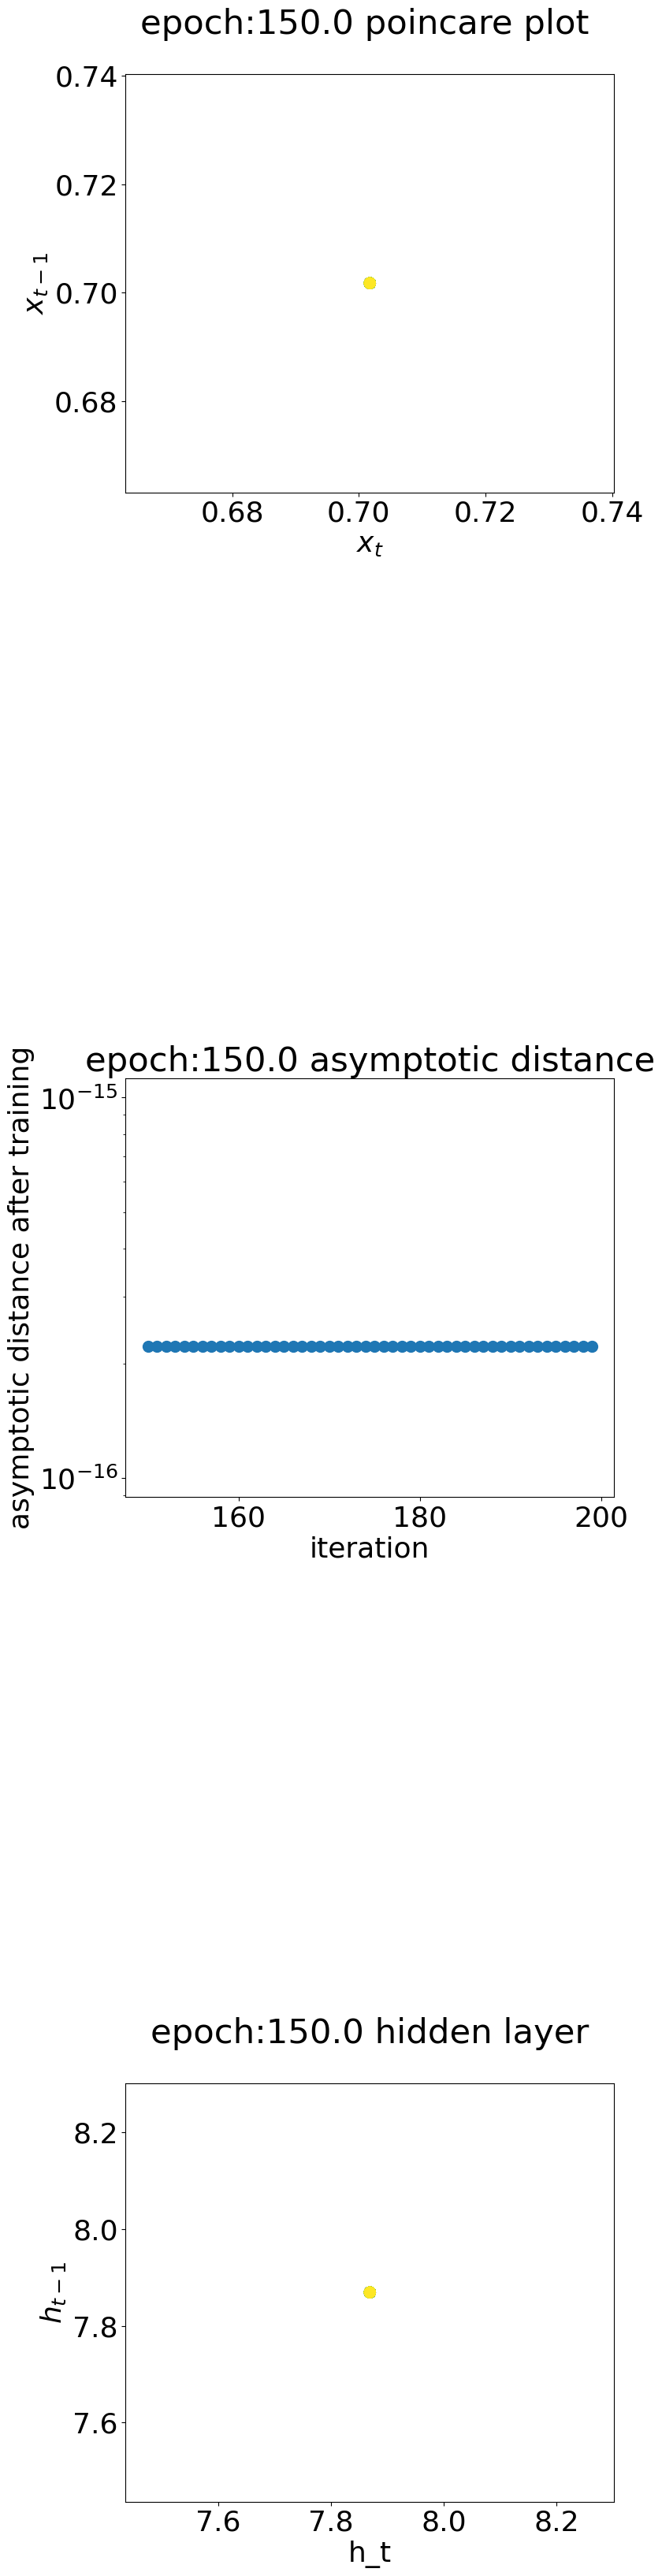

epoch : 151/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 152/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 153/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 154/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 155/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 156/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 157/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 158/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 159/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 160/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 161/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 162/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 163/1000, training loss = 0.374790,validation loss = 0.373407
epoch : 164/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 165/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 0.15800849  0.32432573  0.61655651 ...  0.36897711 -0.16104277
  -0.33090054]
 [-0.75590643  0.15257452  0.31260272 ...  0.90111577 -0.60356773
   0.25671689]
 [-0.45964223 -0.6006699   0.75516149 ...  0.13661776  0.27853451
  -0.29624534]
 ...
 [ 0.86682022  1.49002741 -0.30922282 ...  0.09632707  0.19447568
   0.10834569]
 [ 0.2192965   0.4619779  -0.46359726 ... -0.57800664 -0.88531772
  -0.80376537]
 [ 0.85765559  0.19037868  0.3956526  ... -0.1851545  -0.38395193
   0.25814787]]
(tensor(0.0007, grad_fn=<MeanBackward0>), tensor(0.2978, grad_fn=<VarBackward0>), tensor(0.0036, grad_fn=<MeanBackward0>), tensor(0.3341, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840e5fa570>
819541
40976.80000000005
[[ 0.41154471 -0.16834879 -0.37076455 ...  0.19652201  0.40951535
  -0.60066328]
 [-0.63510219 -0.02705229 -0.05414423 ...  0.35240485 -0.76681485
  -1.05803483]
 [ 1.41915257 -0.67650042 -0.88827733 ...  0.28786564  0.63332623
   0.18947885

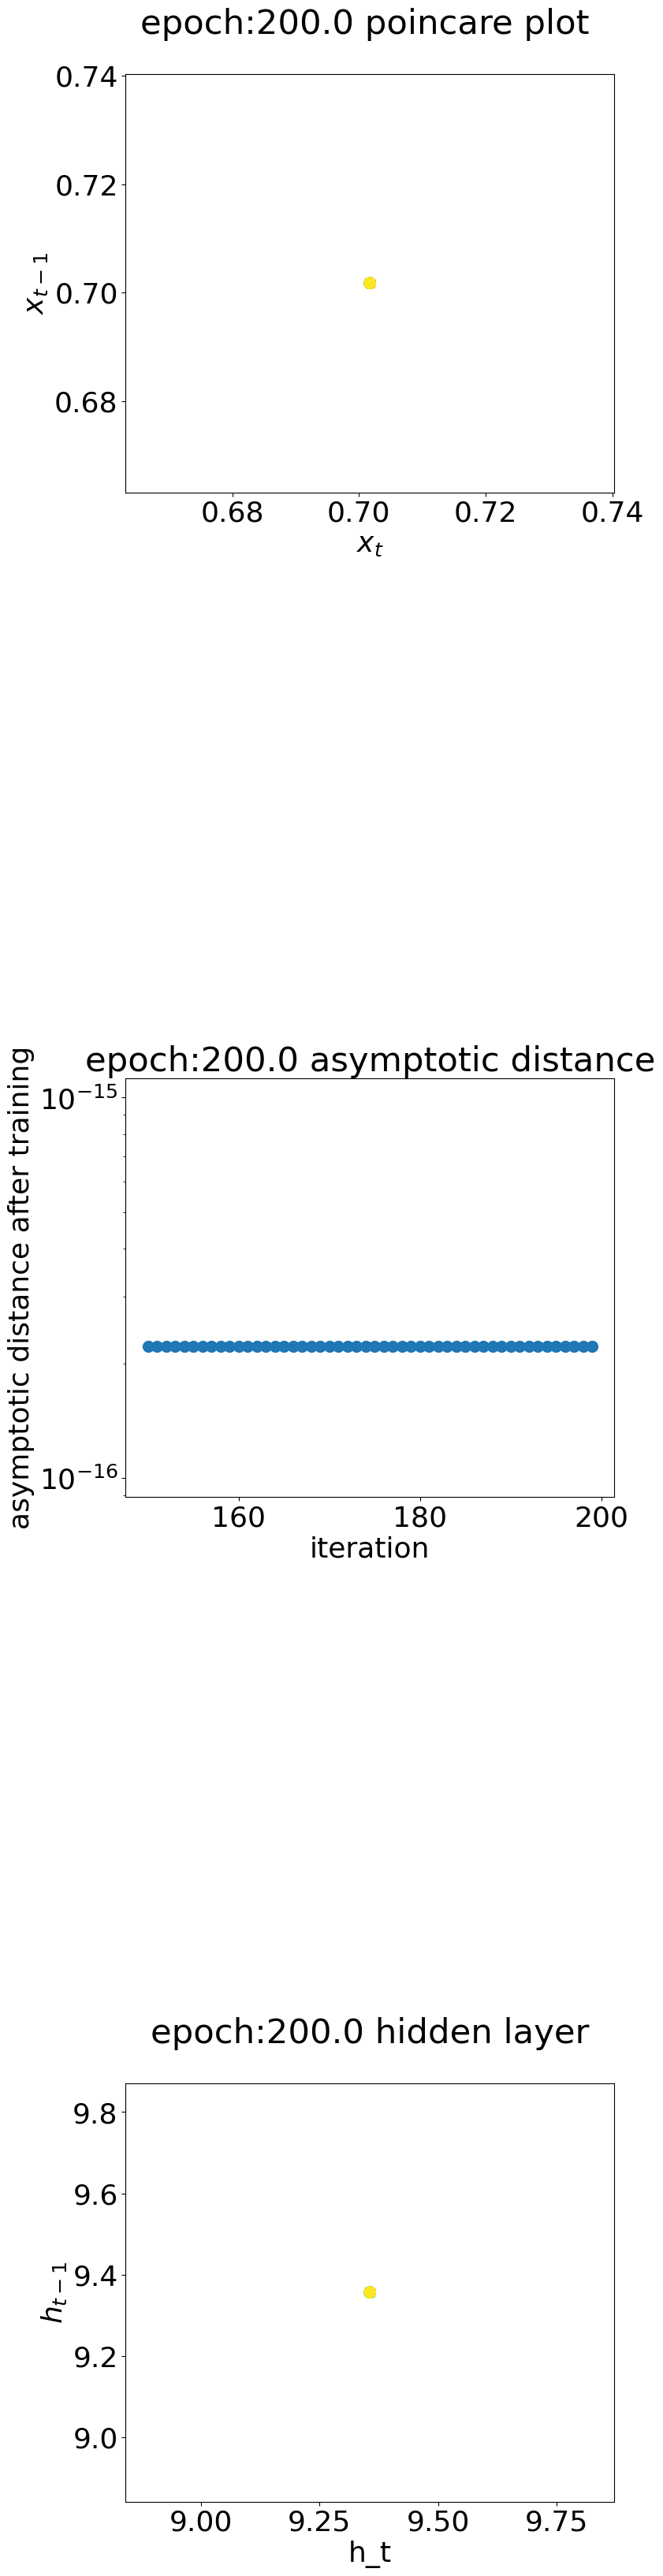

epoch : 201/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 202/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 203/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 204/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 205/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 206/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 207/1000, training loss = 0.374790,validation loss = 0.373407
epoch : 208/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 209/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 210/1000, training loss = 0.374790,validation loss = 0.373407
epoch : 211/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 212/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 213/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 214/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 215/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 0.10261314  0.20743387  0.43443135 ...  0.09467374  0.1910757
   0.39721975]
 [ 0.9847973   0.94546699  0.41189403 ... -0.55529898  1.37403387
   0.33516273]
 [ 0.65887515  0.53904239  0.40462839 ...  0.50710542  0.72497082
   0.66546491]
 ...
 [ 0.03629835  0.07269261  0.14616169 ...  0.39875619  0.99095306
   0.10807584]
 [-0.11630516 -0.23584476  0.42526854 ... -0.67874937  0.9723836
   0.69804478]
 [-0.31733383 -0.59053101 -1.2300664  ...  1.19892677  0.37161369
   0.71012314]]
(tensor(-0.0004, grad_fn=<MeanBackward0>), tensor(0.2984, grad_fn=<VarBackward0>), tensor(0.0026, grad_fn=<MeanBackward0>), tensor(0.3366, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840141f830>
819541
40976.80000000005
[[-0.42808047 -0.94315558 -0.07091039 ...  0.97510331  0.05976893
   0.11996797]
 [ 0.24349208  0.45029435  1.13081029 ...  1.04013893  0.15008344
  -0.05370242]
 [-0.1077164  -0.21799207 -0.45892403 ...  1.02435904 -1.4188895
  -1.49398263]


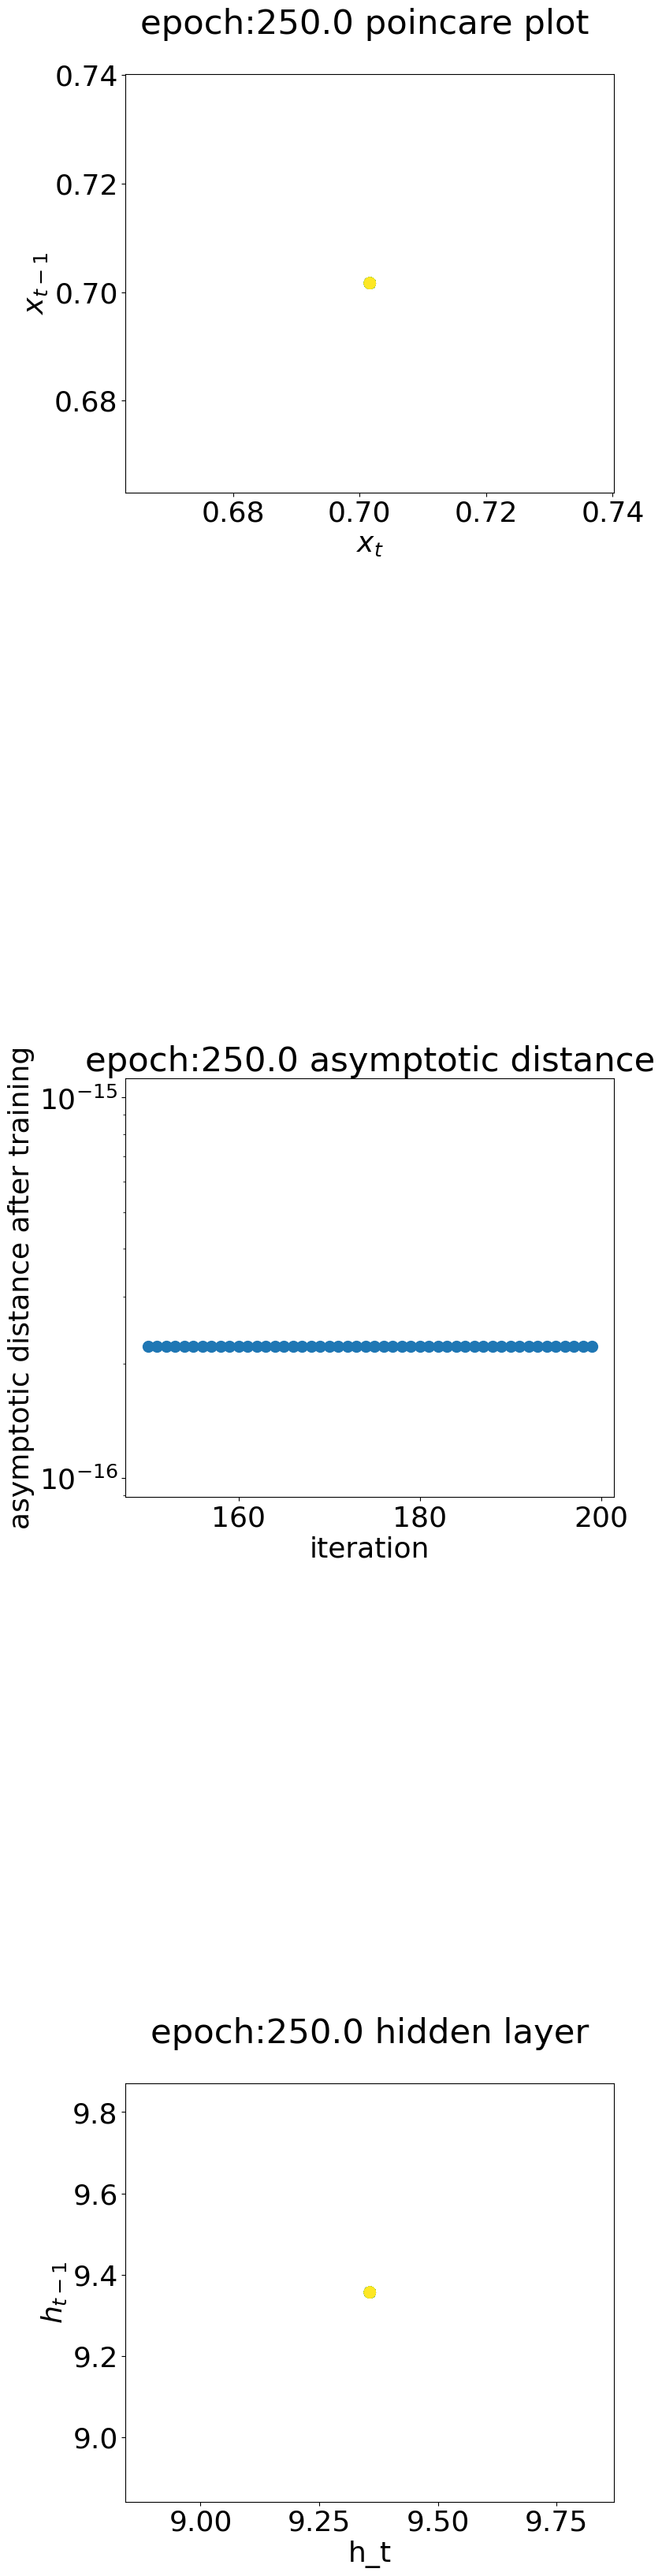

epoch : 251/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 252/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 253/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 254/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 255/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 256/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 257/1000, training loss = 0.374790,validation loss = 0.373406
epoch : 258/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 259/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 260/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 261/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 262/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 263/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 264/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 265/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.75117625  0.08392026  0.16903948 ...  0.29527729  0.3684302
   0.87764132]
 [ 0.53759073  0.78555646  0.08811805 ... -0.35861353 -0.03692676
  -0.07395449]
 [-0.1487269  -0.23052232 -0.48852864 ...  0.26679749 -0.33011234
  -0.07466361]
 ...
 [ 0.26618445 -0.58226687 -0.24870114 ... -1.10722128  0.34614297
  -0.05339627]
 [-0.10709878 -0.21671238 -0.45593419 ... -0.04420862 -0.08859072
  -0.17859425]
 [-0.36936793  0.6445641   0.62386069 ...  0.19478171  0.4055766
  -0.28074507]]
(tensor(-0.0011, grad_fn=<MeanBackward0>), tensor(0.2983, grad_fn=<VarBackward0>), tensor(-0.0028, grad_fn=<MeanBackward0>), tensor(0.3347, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8401271b70>
819541
40976.80000000005
[[-1.90979692e-01  2.56710241e-01 -3.47661282e-04 ... -8.04503392e-01
   1.53164489e+00 -5.61811743e-01]
 [ 4.24322763e-01  1.10176393e+00  3.59819197e-01 ...  4.35053461e-01
  -9.66291048e-01  1.64866273e-01]
 [ 3.39215896e-01 -1.34154641e-

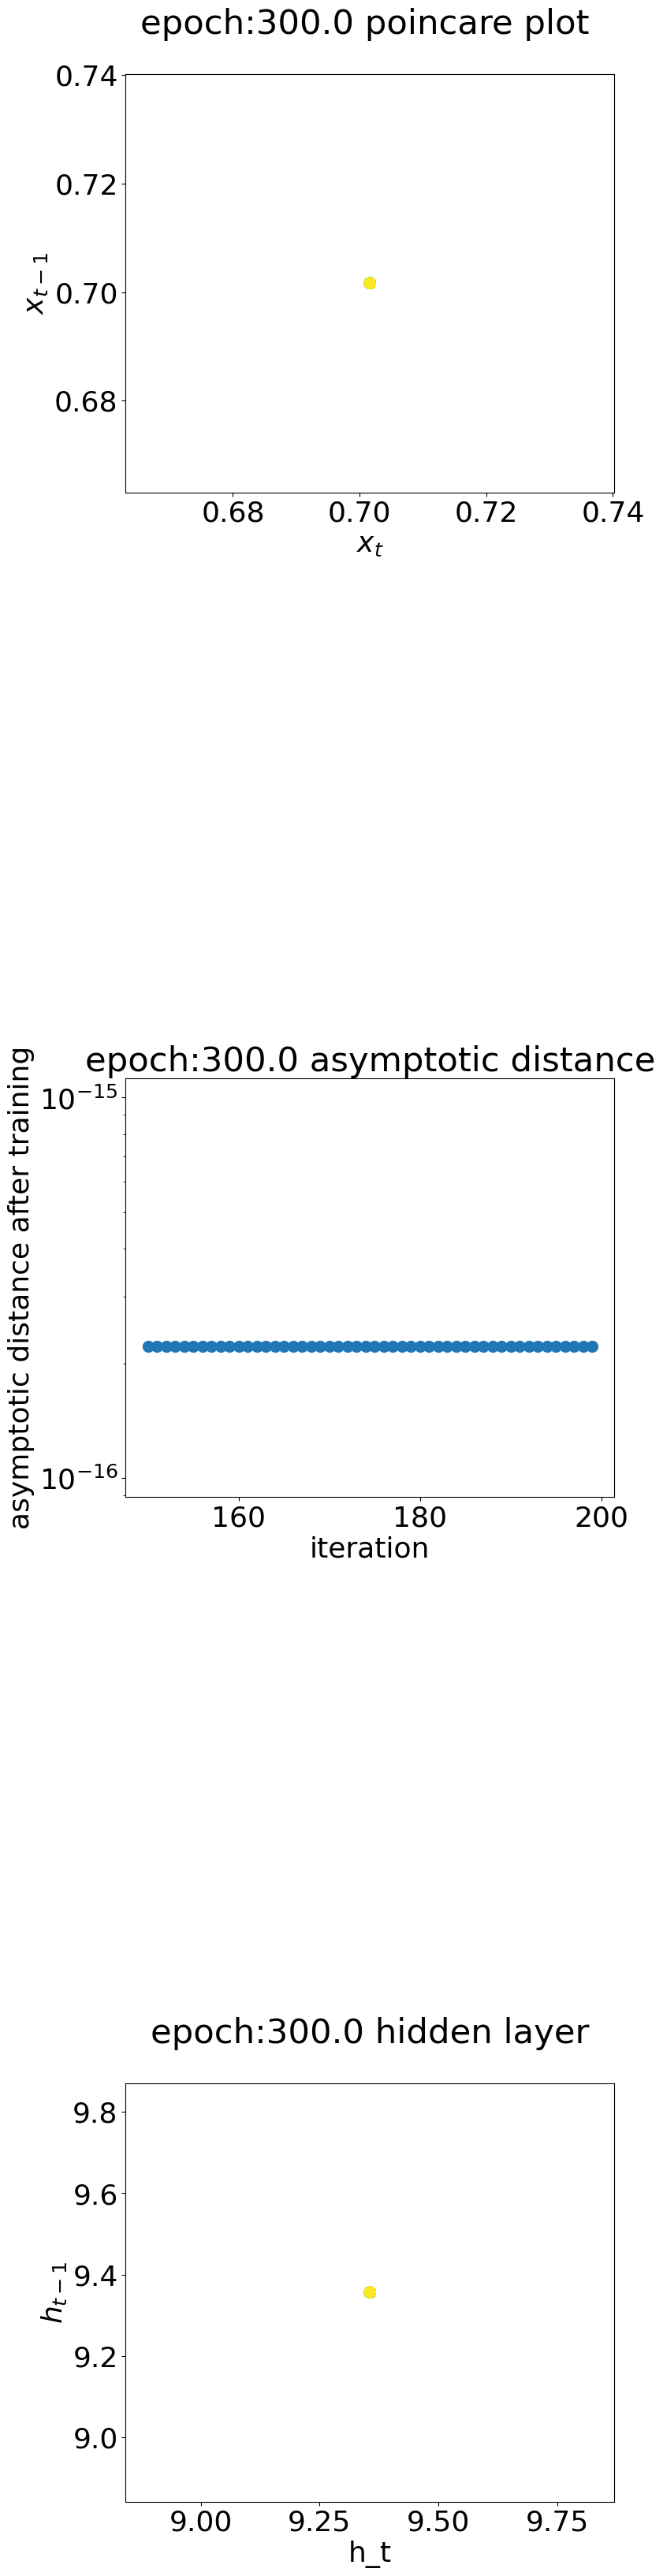

epoch : 301/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 302/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 303/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 304/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 305/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 306/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 307/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 308/1000, training loss = 0.374790,validation loss = 0.373406
epoch : 309/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 310/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 311/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 312/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 313/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 314/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 315/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 0.29213156  0.52959335  0.99227528 ... -0.05463226 -0.1095926
  -0.22188282]
 [ 0.03144579  0.0629539   0.12641078 ...  0.63474865  0.12541722
  -0.27086424]
 [ 0.40336039  0.02366605  0.04735863 ...  0.35491246 -0.72885647
   0.16296528]
 ...
 [ 0.68633061 -0.06831263 -0.13726885 ...  0.9548158  -1.5010971
   0.75142002]
 [-1.0119515  -1.0329768  -0.11827898 ...  0.06259047  0.12567523
  -0.04048636]
 [-0.08110588 -0.16329308 -0.33579034 ...  0.16548967  0.34057494
  -0.77500297]]
(tensor(-6.6788e-06, grad_fn=<MeanBackward0>), tensor(0.2971, grad_fn=<VarBackward0>), tensor(-0.0004, grad_fn=<MeanBackward0>), tensor(0.3423, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f84016dbf60>
819541
40976.80000000005
[[-0.24308193 -0.51884655 -0.04247758 ...  0.56017187  0.54119645
   0.39610318]
 [-0.01925997 -0.03853423 -0.07718324 ...  0.01419539  0.02839651
   0.05683889]
 [ 0.11404743  0.2679952  -0.13773087 ...  0.29584884  0.65498805
   0.7358

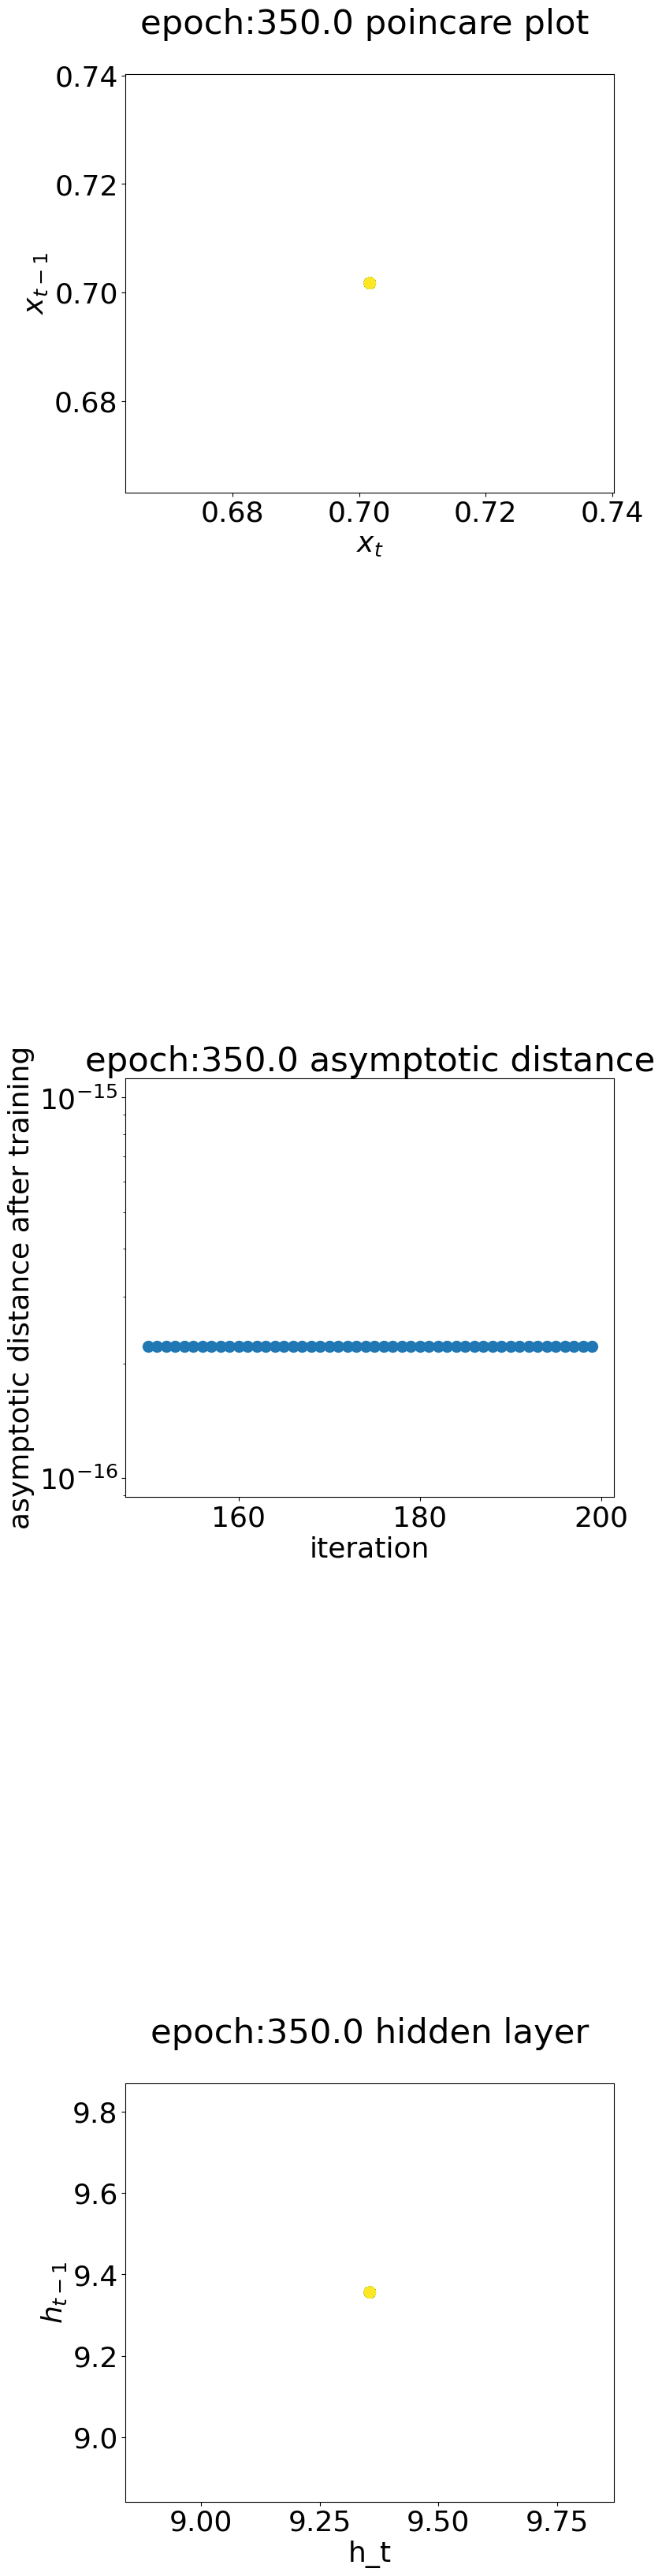

epoch : 351/1000, training loss = 0.374790,validation loss = 0.373407
epoch : 352/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 353/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 354/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 355/1000, training loss = 0.374790,validation loss = 0.373409
epoch : 356/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 357/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 358/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 359/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 360/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 361/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 362/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 363/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 364/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 365/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.22342308  0.16111086  0.33104833 ... -0.77250949 -0.84646589
   0.49085851]
 [ 0.46809891 -0.44464512 -0.93457554 ...  0.06776772  0.13616366
   0.27757227]
 [ 0.60601143  0.64065545  0.09988335 ...  0.04922492  0.09868955
   0.19933984]
 ...
 [-0.87525885  0.63197957  0.64508853 ... -0.2753213  -0.60012521
  -1.00007354]
 [ 1.3942008   0.85607669  1.0313504  ... -0.79571461  0.72118931
  -0.05111498]
 [-0.10249847 -0.20719704 -0.4338864  ...  0.58122605  0.63849491
   1.3843571 ]]
(tensor(-0.0002, grad_fn=<MeanBackward0>), tensor(0.2982, grad_fn=<VarBackward0>), tensor(0.0008, grad_fn=<MeanBackward0>), tensor(0.3282, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840100dee0>
819541
40976.80000000005
[[-0.42113469 -1.0869762   0.57311818 ... -0.08034002 -0.16173075
   0.15606852]
 [ 0.32013305  0.1103092   0.22337019 ...  0.77436471  0.03587756
   0.07184772]
 [ 0.14444496  0.29518207  0.65316202 ... -0.28643872 -0.62949944
   0.4618756

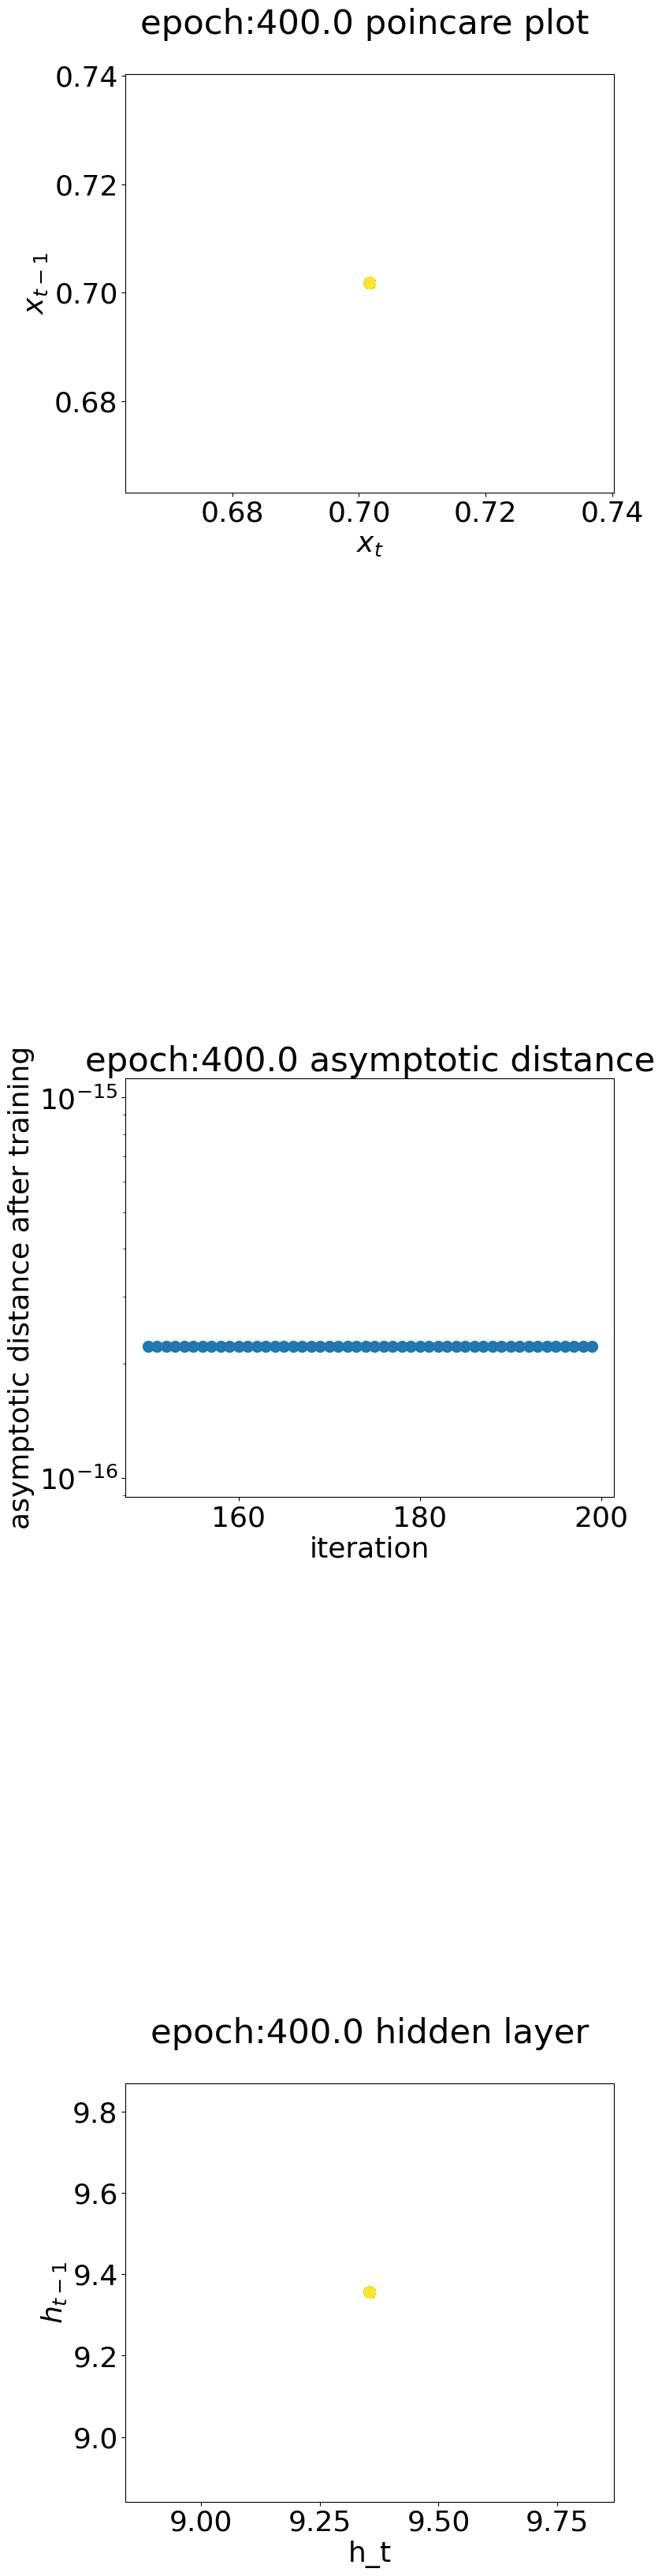

epoch : 401/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 402/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 403/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 404/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 405/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 406/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 407/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 408/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 409/1000, training loss = 0.374790,validation loss = 0.373406
epoch : 410/1000, training loss = 0.374790,validation loss = 0.373409
epoch : 411/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 412/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 413/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 414/1000, training loss = 0.374789,validation loss = 0.373402
epoch : 415/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.10812995 -0.21884925 -0.4609301  ...  0.05972528  0.11987972
   0.2433076 ]
 [ 0.5193976  -0.79262255 -0.00444094 ...  0.38500992  0.93756339
   0.57187207]
 [-0.01850499 -0.03702267 -0.0741471  ...  0.15914243  0.32678033
  -0.74473728]
 ...
 [ 0.21978834  0.46313101  0.01045639 ...  0.17309226  0.35722581
  -0.16068445]
 [-0.33012302  0.75192603  0.28180388 ... -0.51975418  0.47870573
   0.13237349]
 [ 0.26955572  0.58868839  1.61357516 ... -0.00404692 -0.00809397
  -0.01618899]]
(tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.2978, grad_fn=<VarBackward0>), tensor(0.0020, grad_fn=<MeanBackward0>), tensor(0.3197, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840d1e63e0>
819541
40976.80000000005
[[-2.66110977e-01 -5.76346323e-01 -7.20895853e-01 ...  3.26060442e-01
   7.41338148e-01 -4.05202468e-01]
 [-1.01734554e+00 -9.76784499e-02 -1.97257206e-01 ...  2.51299633e-01
  -4.37232592e-01  7.19275983e-01]
 [-2.23859652e-01 -4.91000146e-

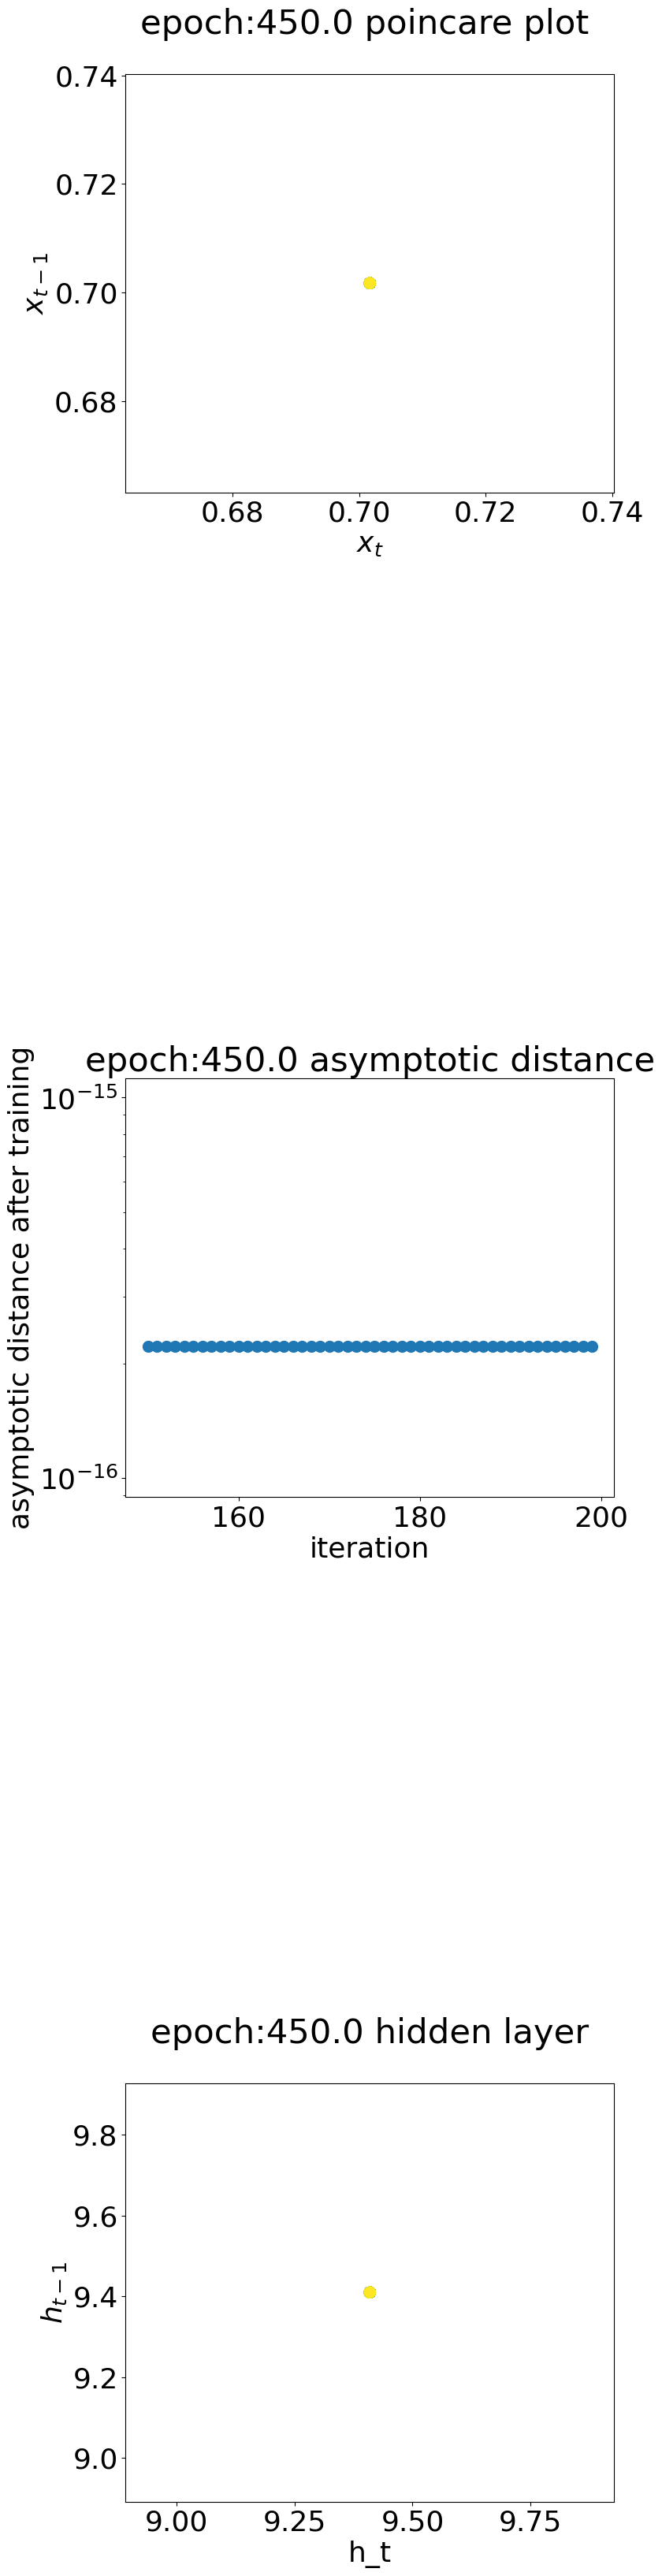

epoch : 451/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 452/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 453/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 454/1000, training loss = 0.374790,validation loss = 0.373412
epoch : 455/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 456/1000, training loss = 0.374790,validation loss = 0.373406
epoch : 457/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 458/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 459/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 460/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 461/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 462/1000, training loss = 0.374790,validation loss = 0.373406
epoch : 463/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 464/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 465/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.56808806  0.80703271 -0.18716367 ... -0.72456329  0.6223488
   0.20122197]
 [ 0.42019987 -0.90629907 -0.63342457 ... -0.28769472  0.21883667
   0.11341851]
 [ 0.22983242 -0.26504352 -0.15269898 ...  0.97597603 -1.07089333
   0.35258693]
 ...
 [ 0.41184593  0.36573466  0.86830219 ...  0.25106964 -0.16920487
  -0.34869388]
 [ 0.48088597 -0.23148504  0.44391848 ... -0.3603838  -0.85006629
  -0.49780496]
 [ 0.26929783 -0.48590436  0.80502635 ...  1.45634206 -1.31808278
   0.4085541 ]]
(tensor(-0.0004, grad_fn=<MeanBackward0>), tensor(0.2987, grad_fn=<VarBackward0>), tensor(0.0008, grad_fn=<MeanBackward0>), tensor(0.3317, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840e52af20>
819541
40976.80000000005
[[ 0.24261154  0.51769864 -1.18774829 ...  0.98213223 -1.3208486
  -0.07536105]
 [-0.15158796 -0.05861409 -0.11763372 ... -0.30318552 -0.53185054
   0.96177688]
 [ 0.99413824  0.59634422 -0.39027126 ...  0.89863068  0.88705736
  -1.19105077]

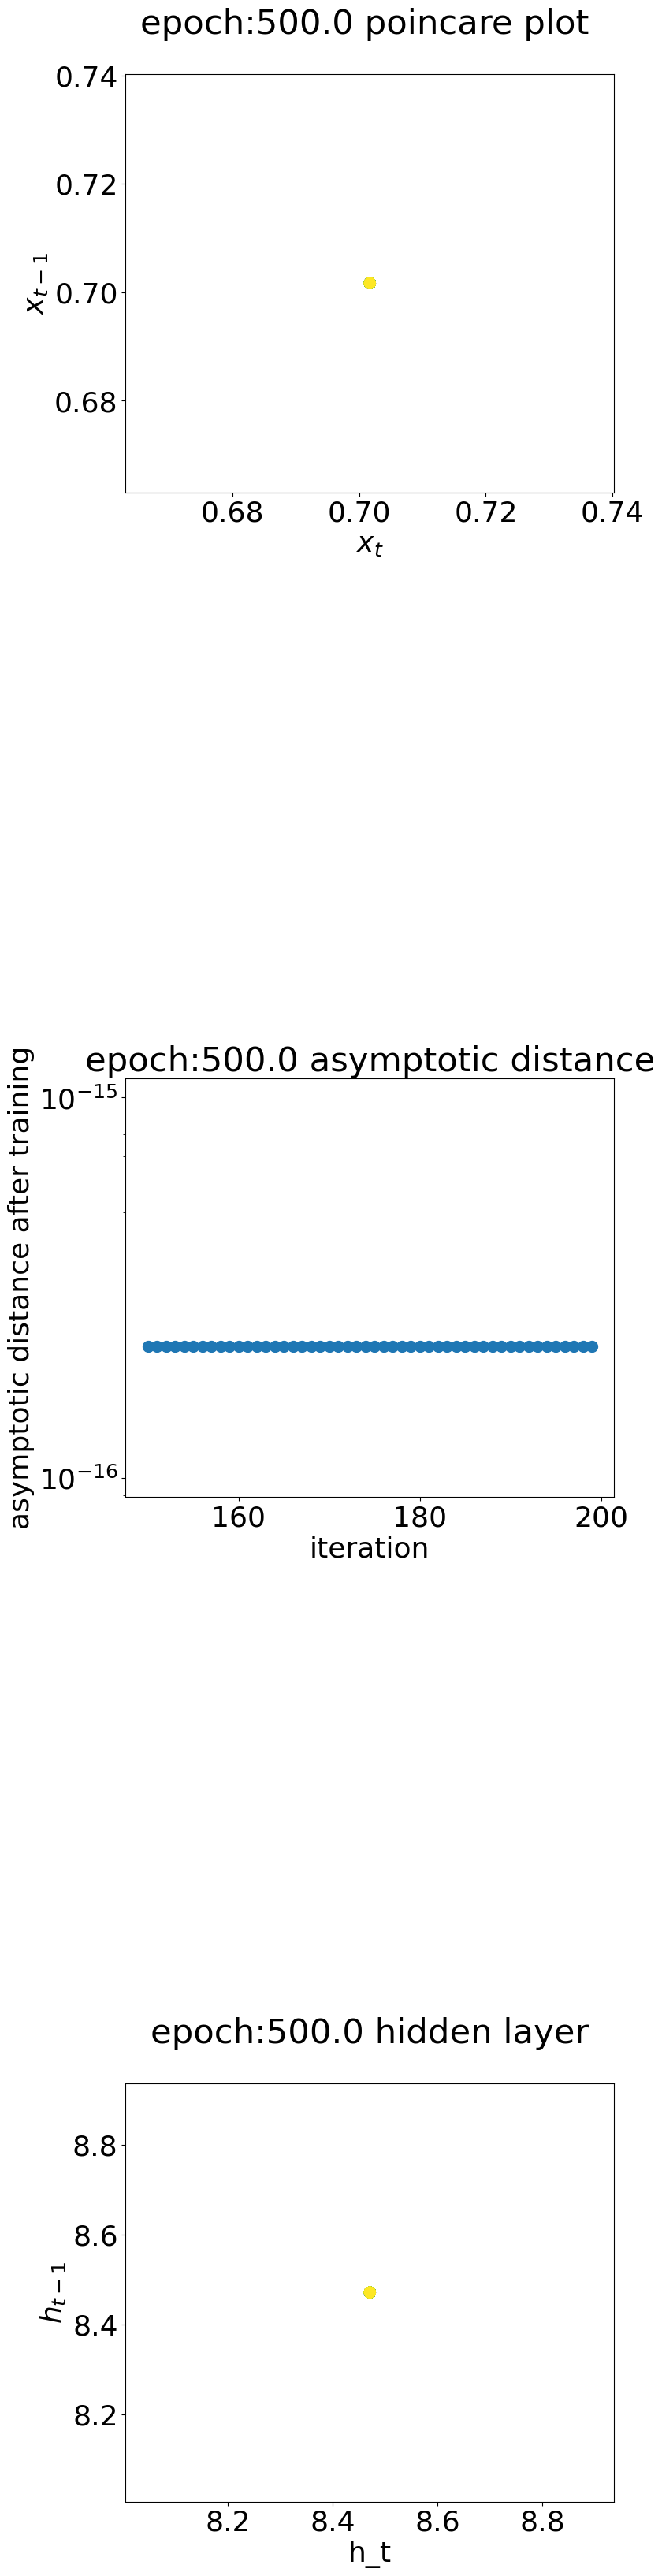

epoch : 501/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 502/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 503/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 504/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 505/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 506/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 507/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 508/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 509/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 510/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 511/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 512/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 513/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 514/1000, training loss = 0.374790,validation loss = 0.373407
epoch : 515/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.51767584 -0.35810397 -0.06743492 ... -0.30755738 -0.68758241
   1.54187775]
 [-0.46632148 -0.30866711 -0.03420002 ...  1.09245908 -0.23830693
  -0.5072399 ]
 [ 0.87481601 -0.99789396  0.83384232 ... -0.75282367  0.88897651
   0.1522875 ]
 ...
 [-0.99419919 -0.4015445  -0.65424247 ... -0.0153571  -0.03072146
  -0.06150101]
 [-0.12347081 -0.25082535 -0.53788945 ...  1.4559787   0.74300008
  -0.87610491]
 [-1.55844727 -0.06637715 -0.13334442 ... -0.03283082 -0.06573256
  -0.13203811]]
(tensor(0.0005, grad_fn=<MeanBackward0>), tensor(0.2985, grad_fn=<VarBackward0>), tensor(-0.0016, grad_fn=<MeanBackward0>), tensor(0.3341, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f83ea41dcb0>
819541
40976.80000000005
[[ 0.51618675 -0.26464747 -0.57261152 ...  0.3036356   0.2171095
   0.45960316]
 [-0.44215007 -0.30898674 -0.69163299 ... -0.14328173 -0.29270045
   0.3448451 ]
 [ 0.48543852 -0.87632044 -0.0227156  ...  0.23821669 -0.49176581
   0.37859915

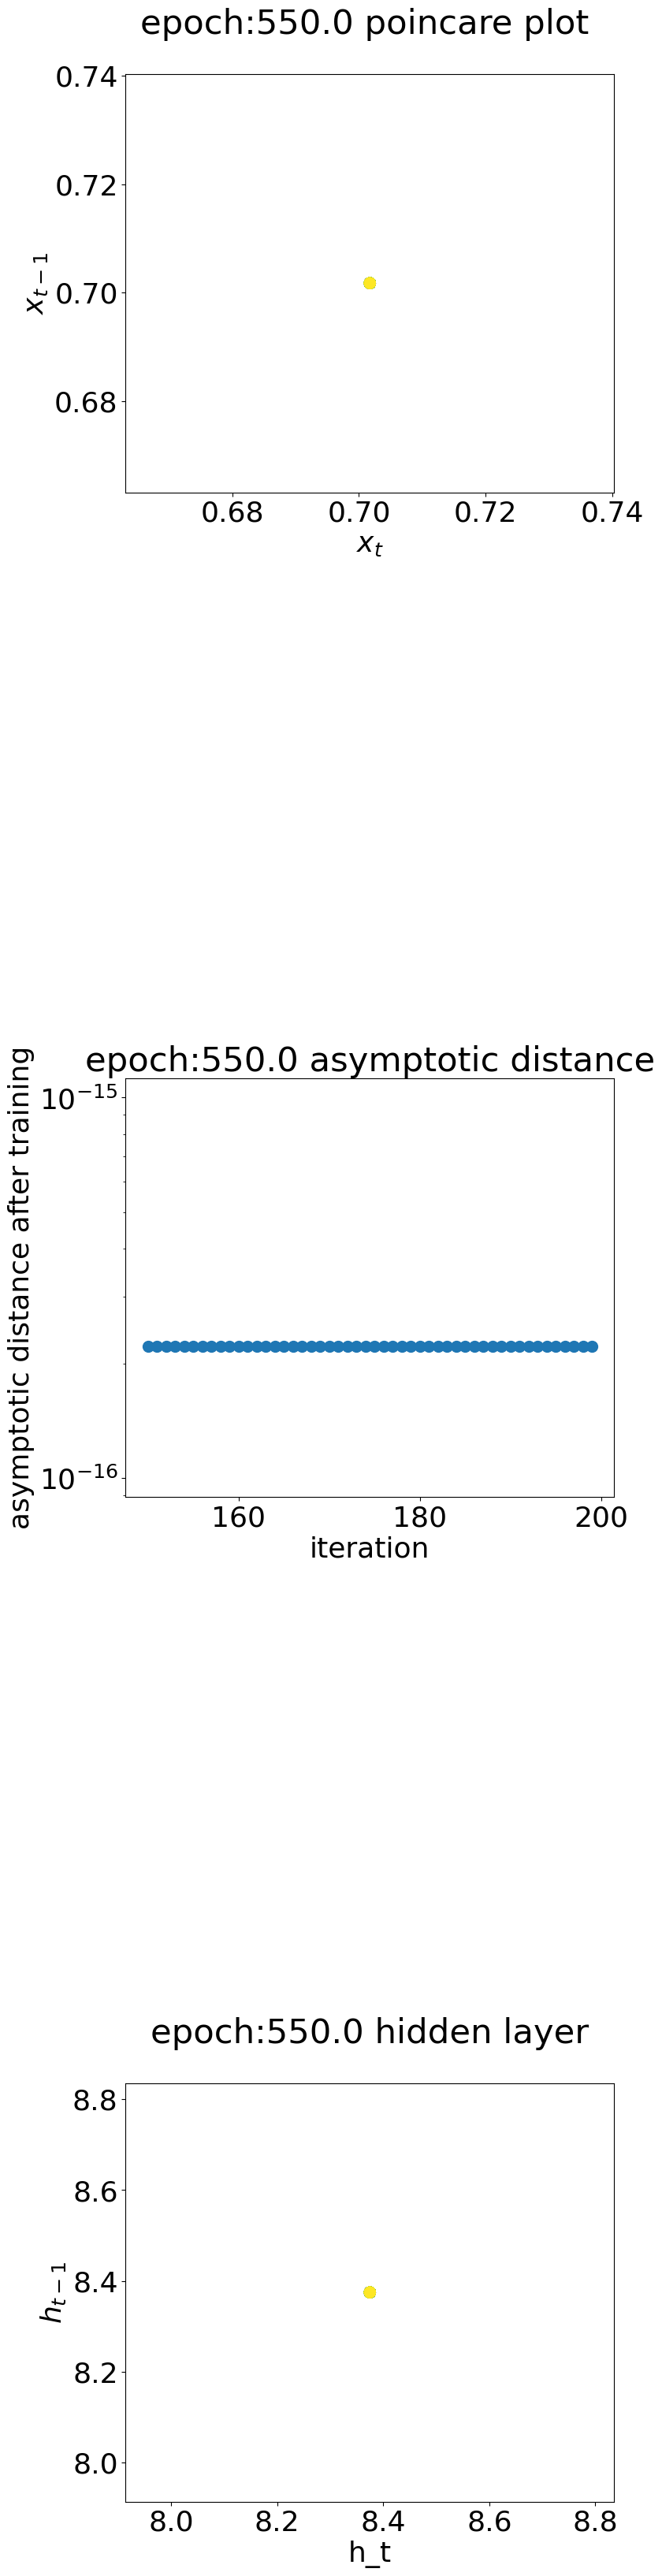

epoch : 551/1000, training loss = 0.374790,validation loss = 0.373409
epoch : 552/1000, training loss = 0.374790,validation loss = 0.373410
epoch : 553/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 554/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 555/1000, training loss = 0.374790,validation loss = 0.373405
epoch : 556/1000, training loss = 0.374790,validation loss = 0.373406
epoch : 557/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 558/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 559/1000, training loss = 0.374790,validation loss = 0.373407
epoch : 560/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 561/1000, training loss = 0.374790,validation loss = 0.373404
epoch : 562/1000, training loss = 0.374790,validation loss = 0.373403
epoch : 563/1000, training loss = 0.374790,validation loss = 0.373401
epoch : 564/1000, training loss = 0.374790,validation loss = 0.373402
epoch : 565/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.5339167   0.43749481 -0.22372186 ... -0.04534033 -0.09086786
  -0.18326157]
 [ 0.29072979  0.64104806 -0.93430564 ... -0.39048768 -0.38732661
   0.22199879]
 [ 0.46832461  0.48418789 -0.28242381 ... -0.35001814 -0.8158107
  -0.80811574]
 ...
 [ 0.17040562  0.35132521  0.47237166 ... -0.04666953 -0.09354324
  -0.18875281]
 [ 0.29884751  0.28321585  0.62090467 ... -0.26101291 -0.56338602
   0.66319888]
 [ 0.54929092  0.40518911  0.27495659 ... -0.38261003 -0.21159093
  -0.44402786]]
(tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.2986, grad_fn=<VarBackward0>), tensor(-0.0017, grad_fn=<MeanBackward0>), tensor(0.3268, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840140d620>
819541
40976.80000000005
[[ 1.96876618e-02  3.93905975e-02  7.89038142e-02 ... -6.63259590e-01
  -1.00086897e-01 -2.02220165e-01]
 [-3.82426969e-01  2.75733890e-01 -5.54509894e-01 ... -1.33826946e+00
  -5.57218966e-02 -2.00907746e-03]
 [-4.01817115e-03  6.70487213e-

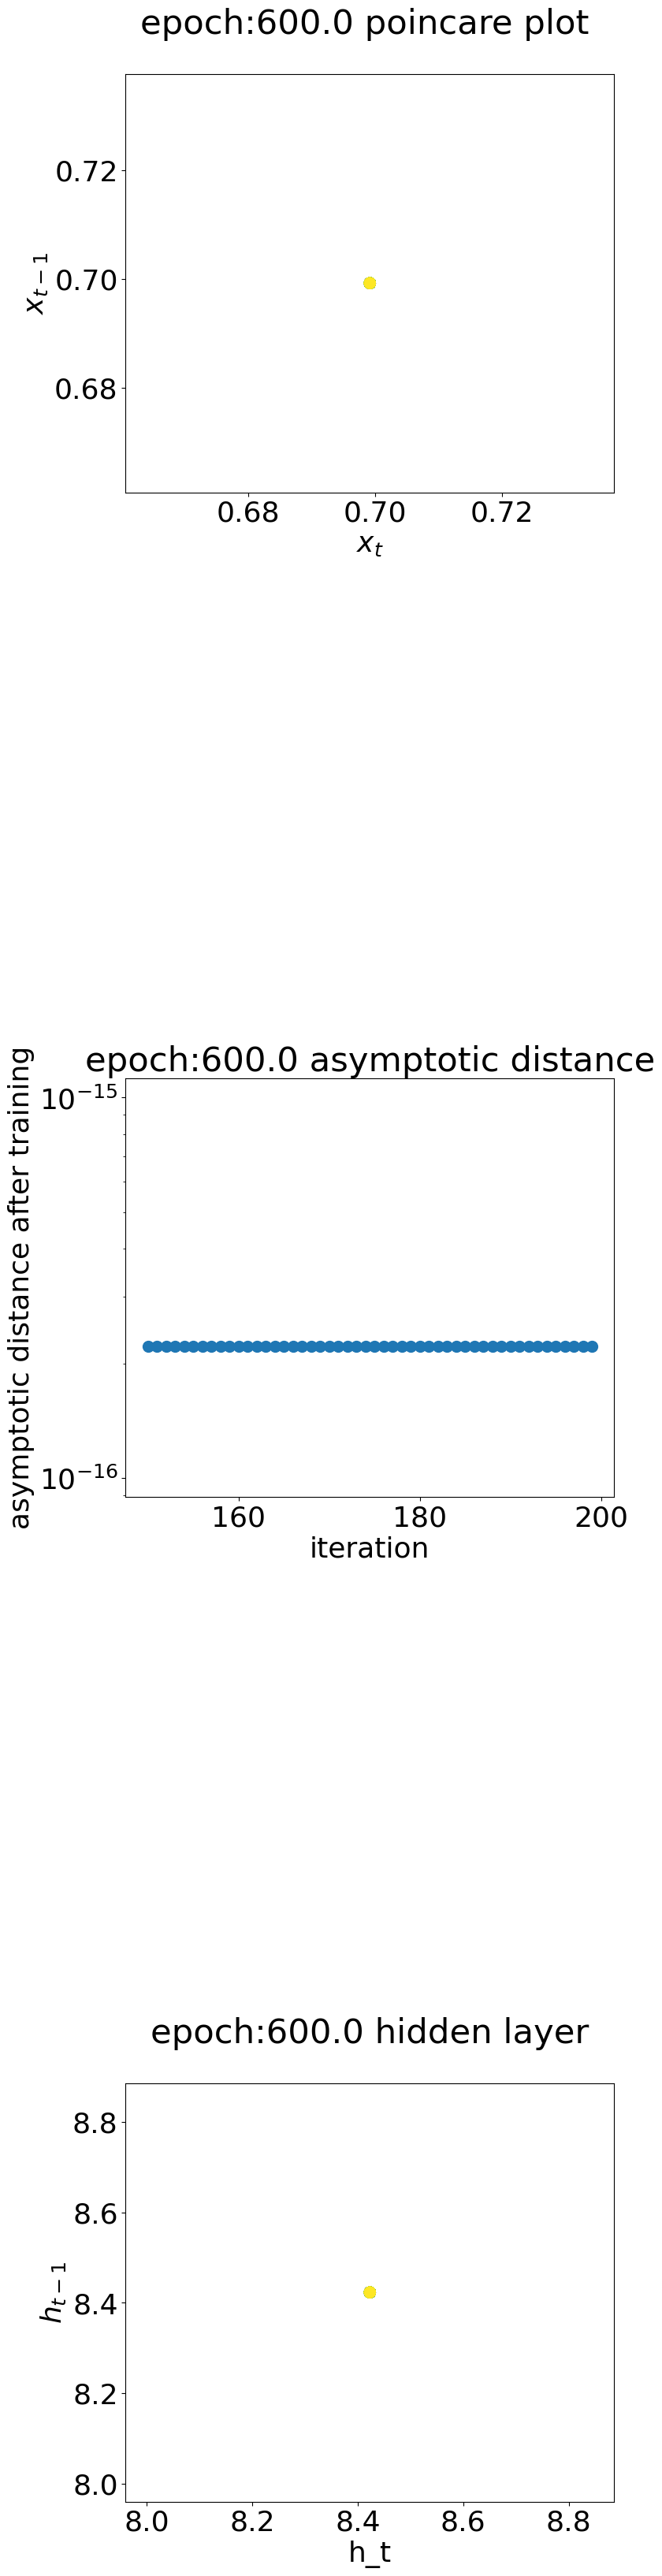

epoch : 601/1000, training loss = 0.375693,validation loss = 0.374295
epoch : 602/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 603/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 604/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 605/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 606/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 607/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 608/1000, training loss = 0.375693,validation loss = 0.374298
epoch : 609/1000, training loss = 0.375693,validation loss = 0.374302
epoch : 610/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 611/1000, training loss = 0.375693,validation loss = 0.374295
epoch : 612/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 613/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 614/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 615/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 0.35512434 -0.46904519  0.18963085 ...  0.02999862 -0.05429726
  -0.10891659]
 [-0.22048038 -0.20357909 -0.42558504 ...  0.30326274  0.6755078
  -0.01645183]
 [ 0.09756283 -0.22936689 -0.06125584 ...  0.88818785 -1.51796
  -0.37119422]
 ...
 [-0.40755405 -0.86216212 -0.86462552 ... -0.16457444 -0.15816935
  -0.32467377]
 [-0.73720526 -0.89662799 -0.34342196 ... -0.08762571 -0.17661809
  -0.36499765]
 [ 0.44365495 -0.54582427 -0.89264058 ...  0.40962198  0.94105103
  -0.91937554]]
(tensor(-0.0006, grad_fn=<MeanBackward0>), tensor(0.2971, grad_fn=<VarBackward0>), tensor(-0.0014, grad_fn=<MeanBackward0>), tensor(0.3418, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8400f9cbd0>
819541
40976.80000000005
[[-2.08604434e-01 -2.37086265e-01 -4.27156731e-01 ... -1.11062794e-01
  -2.24935125e-01  1.52027948e-01]
 [ 3.11427131e-01  3.46396511e-01 -3.18960920e-06 ...  7.47532091e-02
   1.50351329e-01 -1.00121303e-01]
 [-1.99795535e-01 -1.20390399e-01

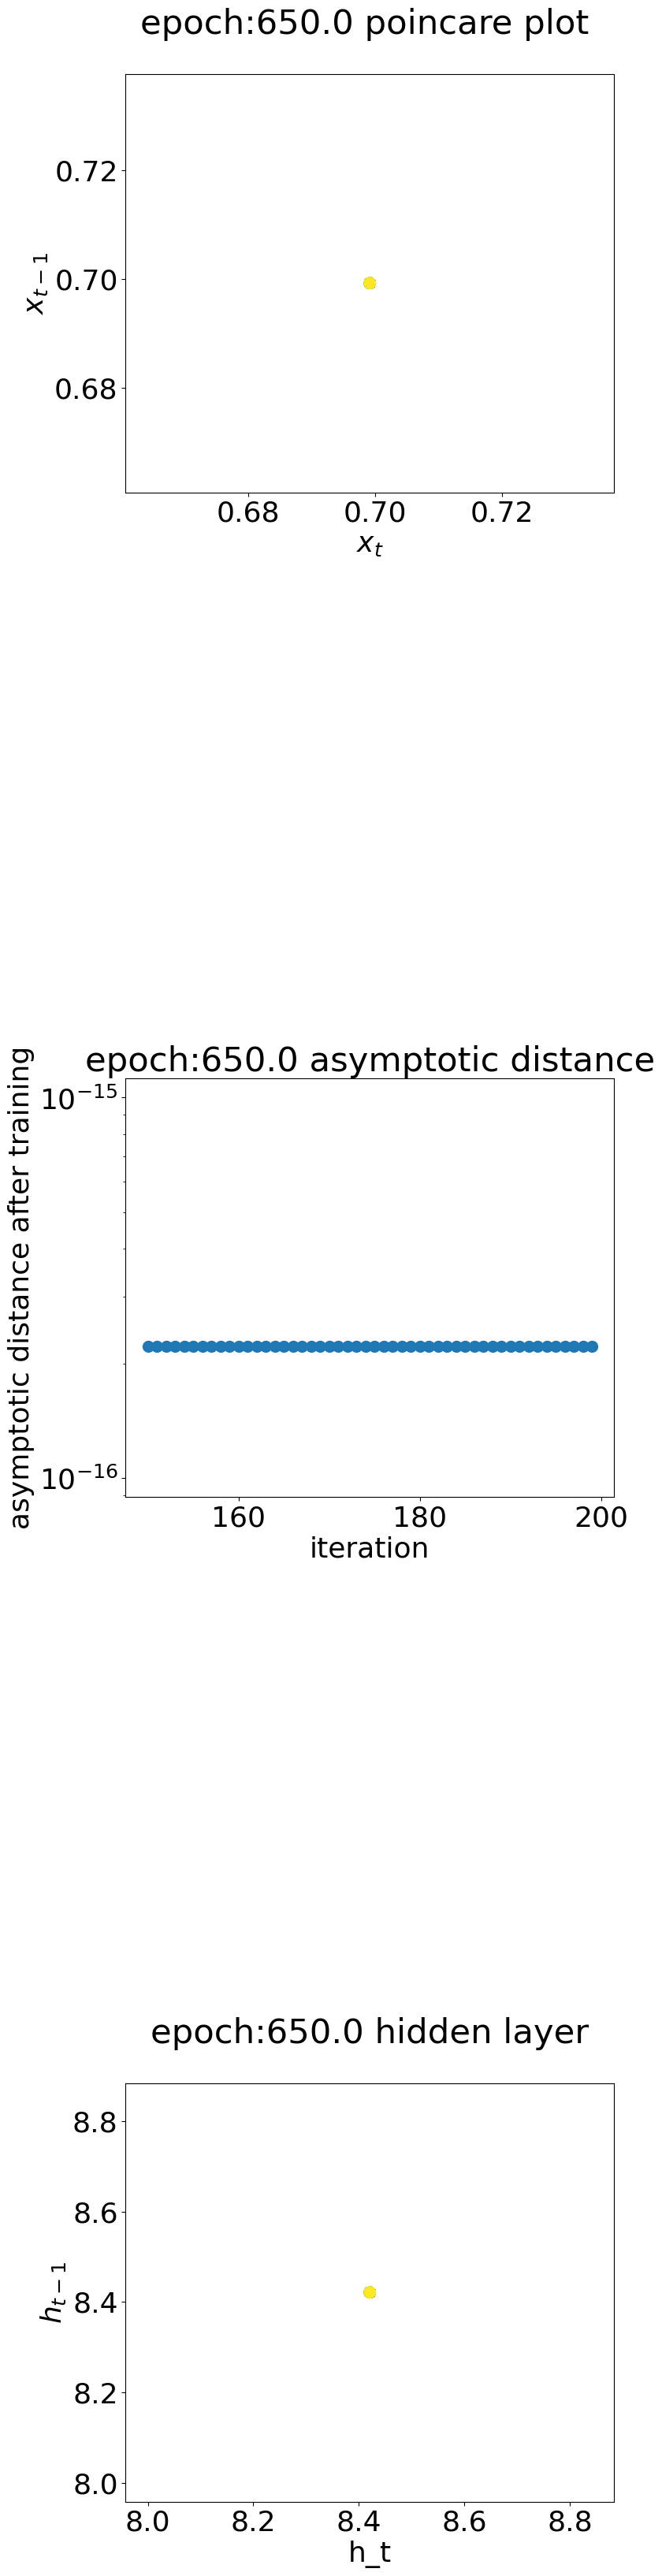

epoch : 651/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 652/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 653/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 654/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 655/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 656/1000, training loss = 0.375693,validation loss = 0.374298
epoch : 657/1000, training loss = 0.375693,validation loss = 0.374303
epoch : 658/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 659/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 660/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 661/1000, training loss = 0.375693,validation loss = 0.374298
epoch : 662/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 663/1000, training loss = 0.375693,validation loss = 0.374297
epoch : 664/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 665/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.23282866 -0.49404571  1.32215708 ... -0.82170431 -0.11830195
  -0.24001112]
 [-0.51137072  1.08771456  0.06873317 ... -0.60346581 -1.30027633
  -0.23251028]
 [-0.49328281 -1.05664599  0.84632799 ... -0.32357062 -0.73393006
   0.82001248]
 ...
 [-0.39763732 -0.22021552 -0.40720915 ...  0.60632917 -0.14517205
  -0.2967346 ]
 [-0.47672463  1.23569606 -0.57030817 ... -1.01923016  1.27229837
  -0.11236207]
 [-0.22763519  0.0260427   0.05212078 ...  0.28855641  0.63518359
  -0.93295345]]
(tensor(0.0011, grad_fn=<MeanBackward0>), tensor(0.2959, grad_fn=<VarBackward0>), tensor(0.0015, grad_fn=<MeanBackward0>), tensor(0.3478, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8400f5a1b0>
819541
40976.80000000005
[[ 0.73196433 -0.82598937 -1.21957563 ... -0.50780528 -0.57615934
   0.72357363]
 [ 0.68720586  1.36493125 -0.59189433 ...  0.51248608 -0.62970412
   0.61204142]
 [ 0.77487736 -0.81705837  0.5830101  ...  0.75131582  1.11393723
   1.15705643

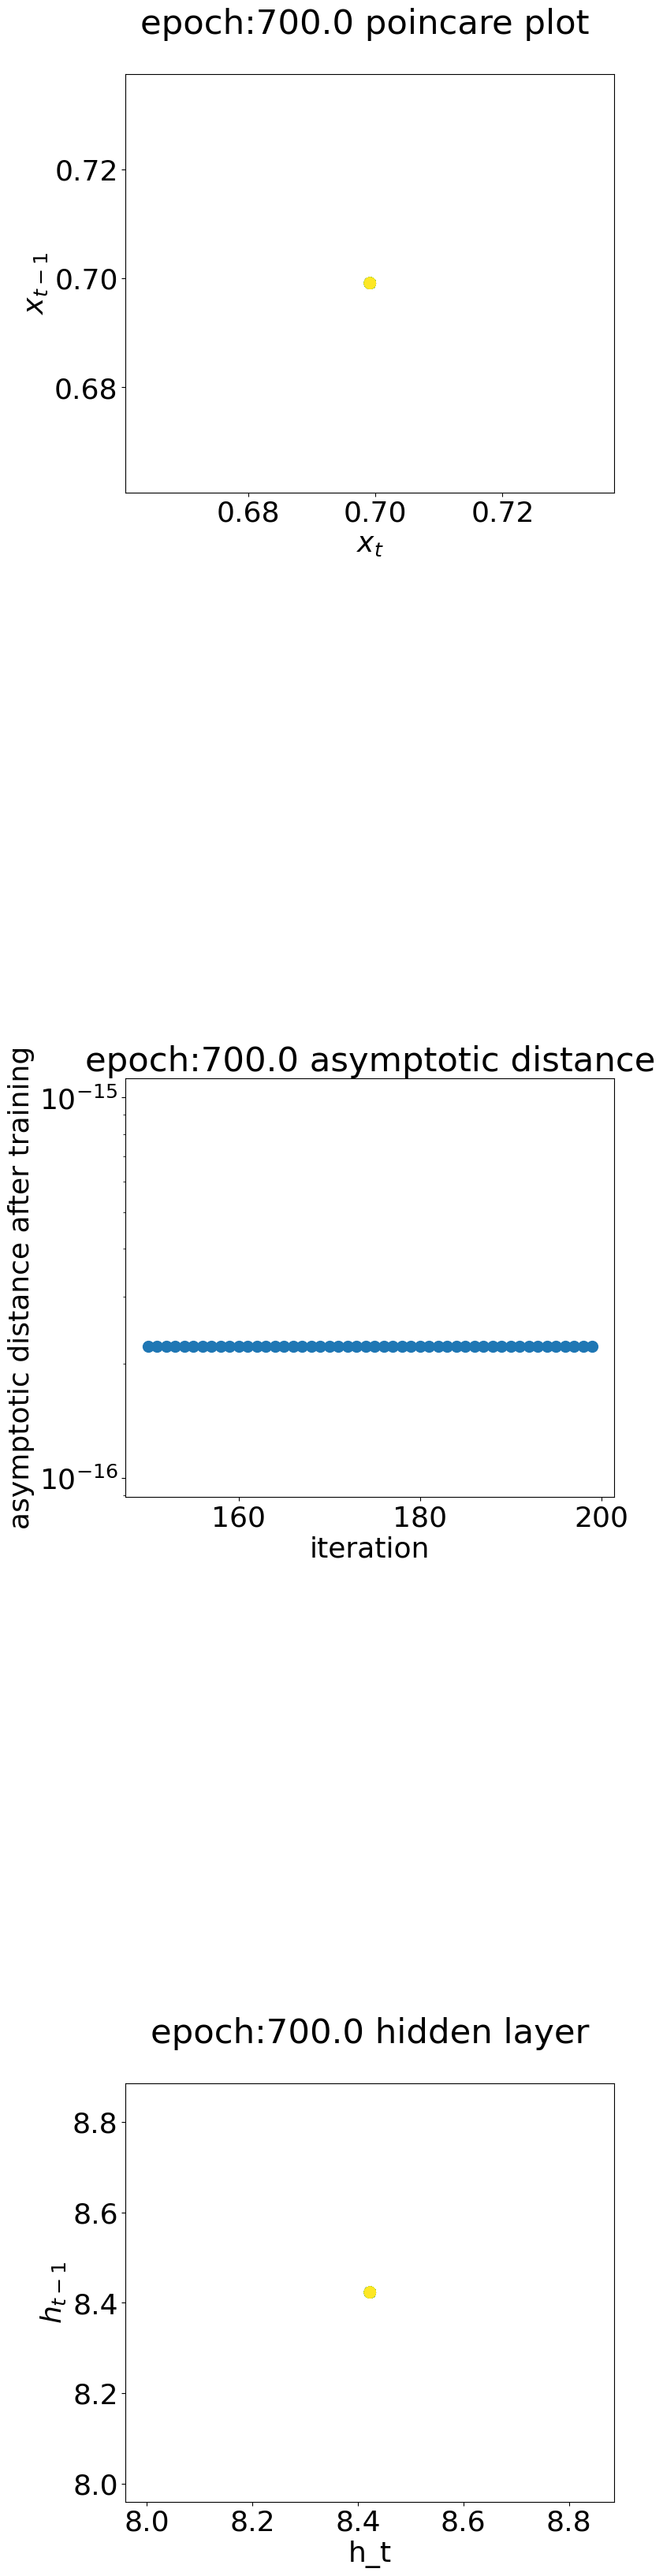

epoch : 701/1000, training loss = 0.375693,validation loss = 0.374296
epoch : 702/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 703/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 704/1000, training loss = 0.375693,validation loss = 0.374297
epoch : 705/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 706/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 707/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 708/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 709/1000, training loss = 0.375693,validation loss = 0.374303
epoch : 710/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 711/1000, training loss = 0.375693,validation loss = 0.374299
epoch : 712/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 713/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 714/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 715/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.09538705 -0.19254219 -0.40052165 ... -0.05398811 -0.10829279
   0.14802663]
 [-0.09516628 -0.19208824 -0.39949886 ... -0.26329876 -0.55567229
   0.37075914]
 [ 0.19916262  0.41550969 -0.56925886 ...  0.29863292  0.66264672
   0.59744385]
 ...
 [ 0.13063108  0.26587906  0.5757537  ...  0.1075092   0.07098418
   0.14269101]
 [ 0.29144125  0.64297473  0.92230361 ... -0.34375214 -0.60553075
  -0.96404154]
 [ 0.01664122  0.19857807  0.41418084 ... -0.24101398 -0.51380753
  -0.39909515]]
(tensor(-0.0002, grad_fn=<MeanBackward0>), tensor(0.2970, grad_fn=<VarBackward0>), tensor(-0.0053, grad_fn=<MeanBackward0>), tensor(0.3387, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f84013b5da0>
819541
40976.80000000005
[[-0.25802088 -0.55584345 -0.97142245 ... -0.50496282  0.53771119
  -0.13433478]
 [-0.17066524 -0.2612956  -0.56410106 ...  0.09460612  0.06417704
  -0.16836201]
 [-0.34684899 -0.80560067  0.35243026 ...  0.94397381 -0.04567043
  -0.091532

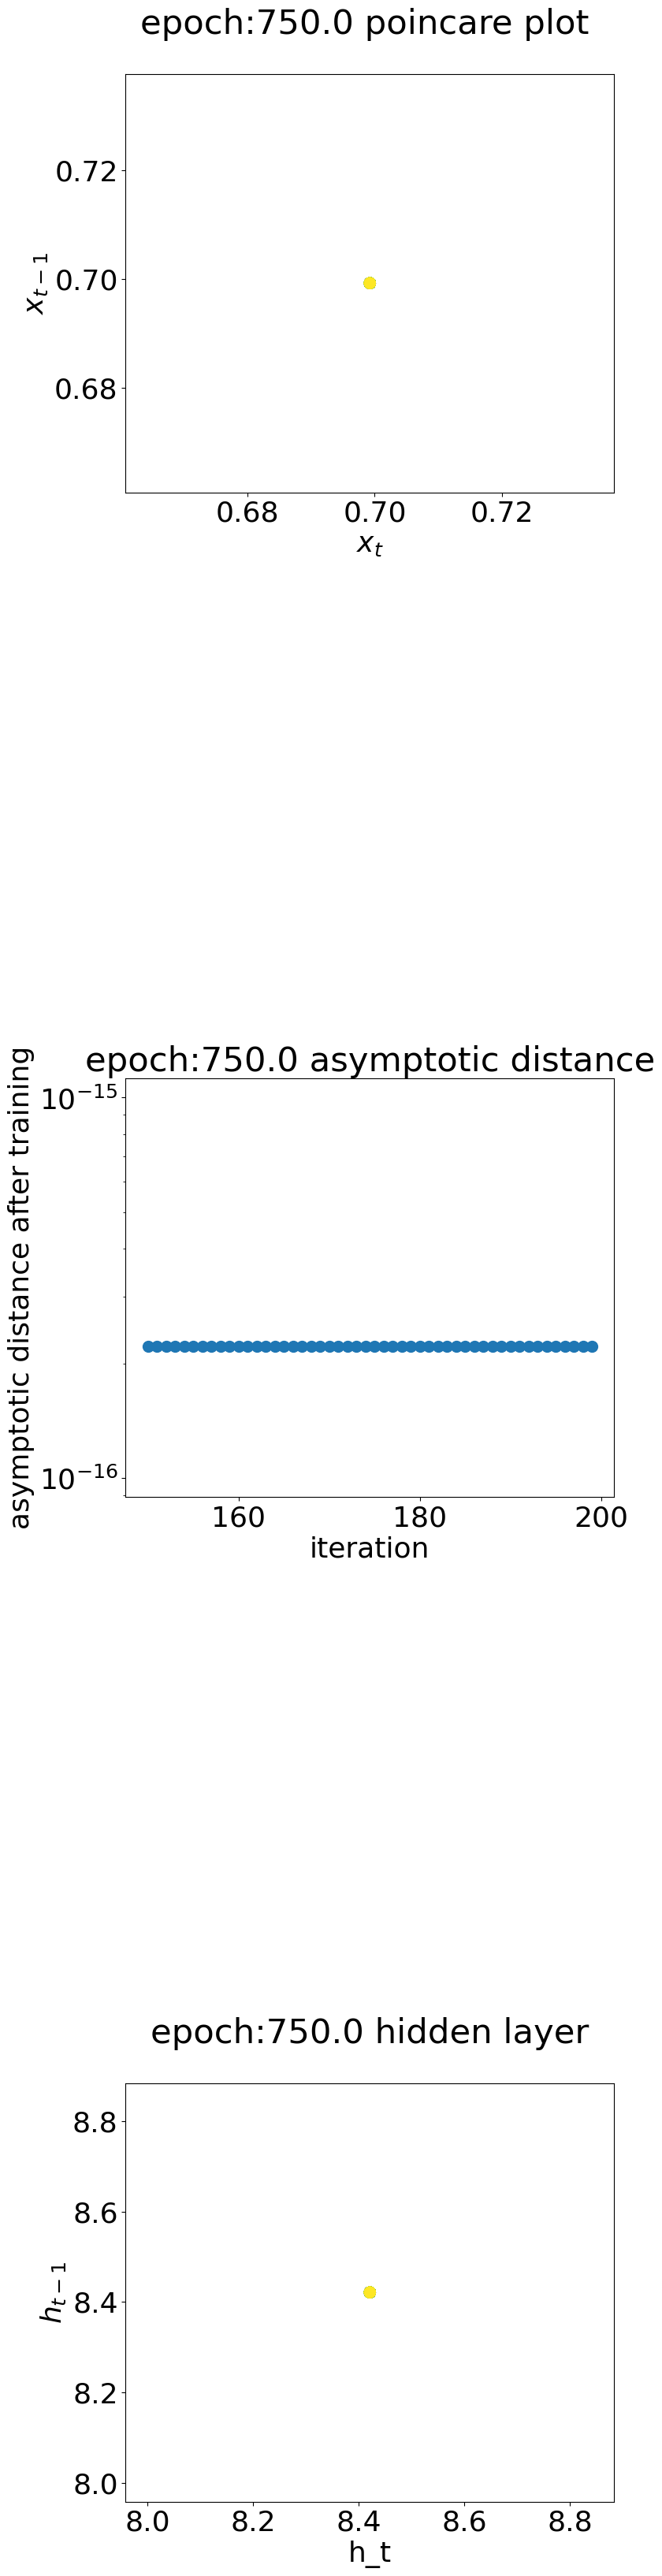

epoch : 751/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 752/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 753/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 754/1000, training loss = 0.375693,validation loss = 0.374298
epoch : 755/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 756/1000, training loss = 0.375693,validation loss = 0.374298
epoch : 757/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 758/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 759/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 760/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 761/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 762/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 763/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 764/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 765/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.26704798 -0.57874364  1.24816989 ... -0.57460711 -1.33285028
  -0.27415309]
 [ 0.03947776  0.07907895  0.15915949 ...  0.52470155  0.95928421
   1.36974979]
 [-0.87853042  0.13965462  0.28497954 ...  0.23735176  0.50493018
  -0.06358669]
 ...
 [ 0.09258156  0.18677798  0.38757964 ...  0.24168724 -0.52523348
  -1.00968029]
 [-1.24558292 -0.84004298  0.12392603 ...  0.22409458 -0.18235244
  -0.37770817]
 [ 0.30086597  0.66883008  0.67752568 ... -0.48619313  0.47559904
  -0.11058206]]
(tensor(0.0015, grad_fn=<MeanBackward0>), tensor(0.2966, grad_fn=<VarBackward0>), tensor(0.0012, grad_fn=<MeanBackward0>), tensor(0.3339, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f83ea419030>
819541
40976.80000000005
[[-0.14311455 -0.29234401 -0.12075322 ... -0.68643514 -0.6531875
  -0.08491429]
 [-0.17107108  0.26434765 -0.03271392 ... -0.17563699 -0.3628318
  -0.85836019]
 [-0.2517101  -0.5400833  -0.11982965 ...  1.19144667  1.01880699
   0.25938192]


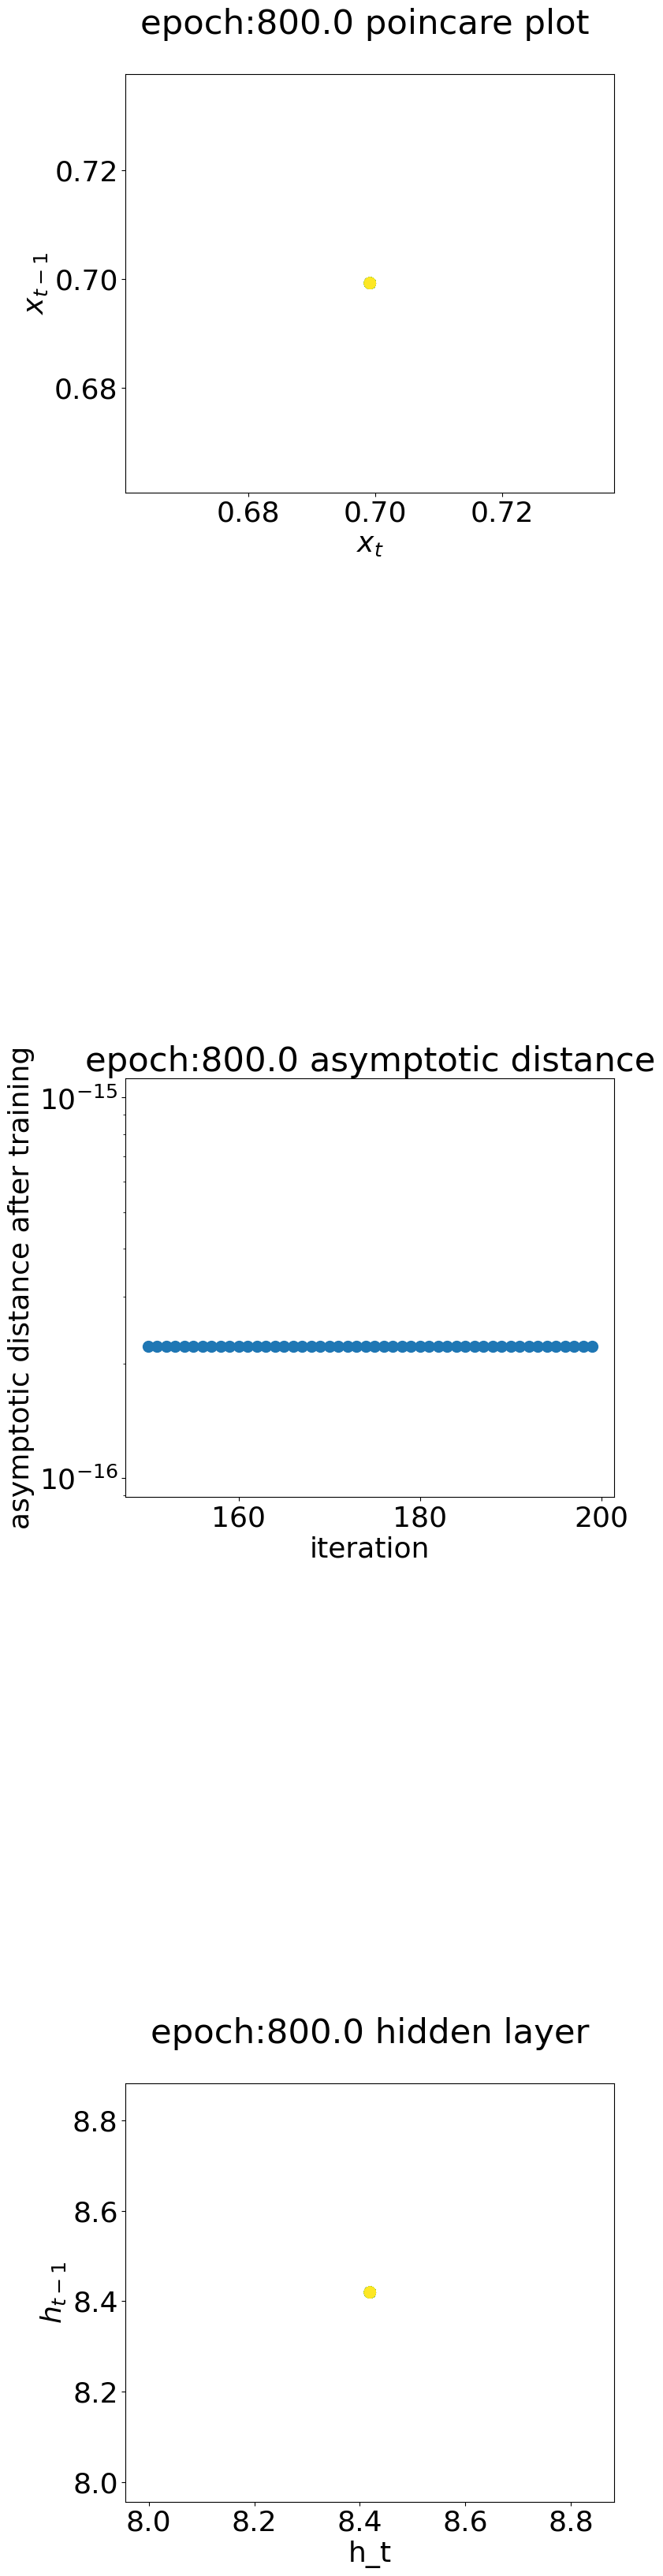

epoch : 801/1000, training loss = 0.375693,validation loss = 0.374303
epoch : 802/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 803/1000, training loss = 0.375693,validation loss = 0.374299
epoch : 804/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 805/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 806/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 807/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 808/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 809/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 810/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 811/1000, training loss = 0.375693,validation loss = 0.374297
epoch : 812/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 813/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 814/1000, training loss = 0.375693,validation loss = 0.374296
epoch : 815/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[ 0.5374679  -0.80003034  0.58582988 ...  0.64459001  0.97508916
   0.12130175]
 [ 0.24628206  0.52668257  0.70042064 ...  0.1853586   0.38440758
   0.93530598]
 [ 0.59419713  0.22327086  0.30718933 ...  0.58764441  0.1417347
   0.2894042 ]
 ...
 [ 0.05672296  0.11381329  0.23065395 ... -0.19444653 -0.15693702
   0.20375953]
 [ 0.42599804  1.10966175  1.35154829 ... -0.12082338  0.14649832
   0.2995693 ]
 [ 0.42710778 -0.38339342 -0.78953675 ... -0.09496247 -0.20826034
  -0.42386268]]
(tensor(-0.0001, grad_fn=<MeanBackward0>), tensor(0.2984, grad_fn=<VarBackward0>), tensor(-0.0043, grad_fn=<MeanBackward0>), tensor(0.3266, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840d314090>
819541
40976.80000000005
[[ 0.62902526  1.02437548  0.17524604 ... -0.01581209 -0.0316321
  -0.06332762]
 [-0.12716729 -0.21172811 -0.44434556 ... -0.05510557 -0.11054786
  -0.22386571]
 [-0.31045051  0.43858791  1.17210737 ...  0.03196927  0.06400403
   0.12853678

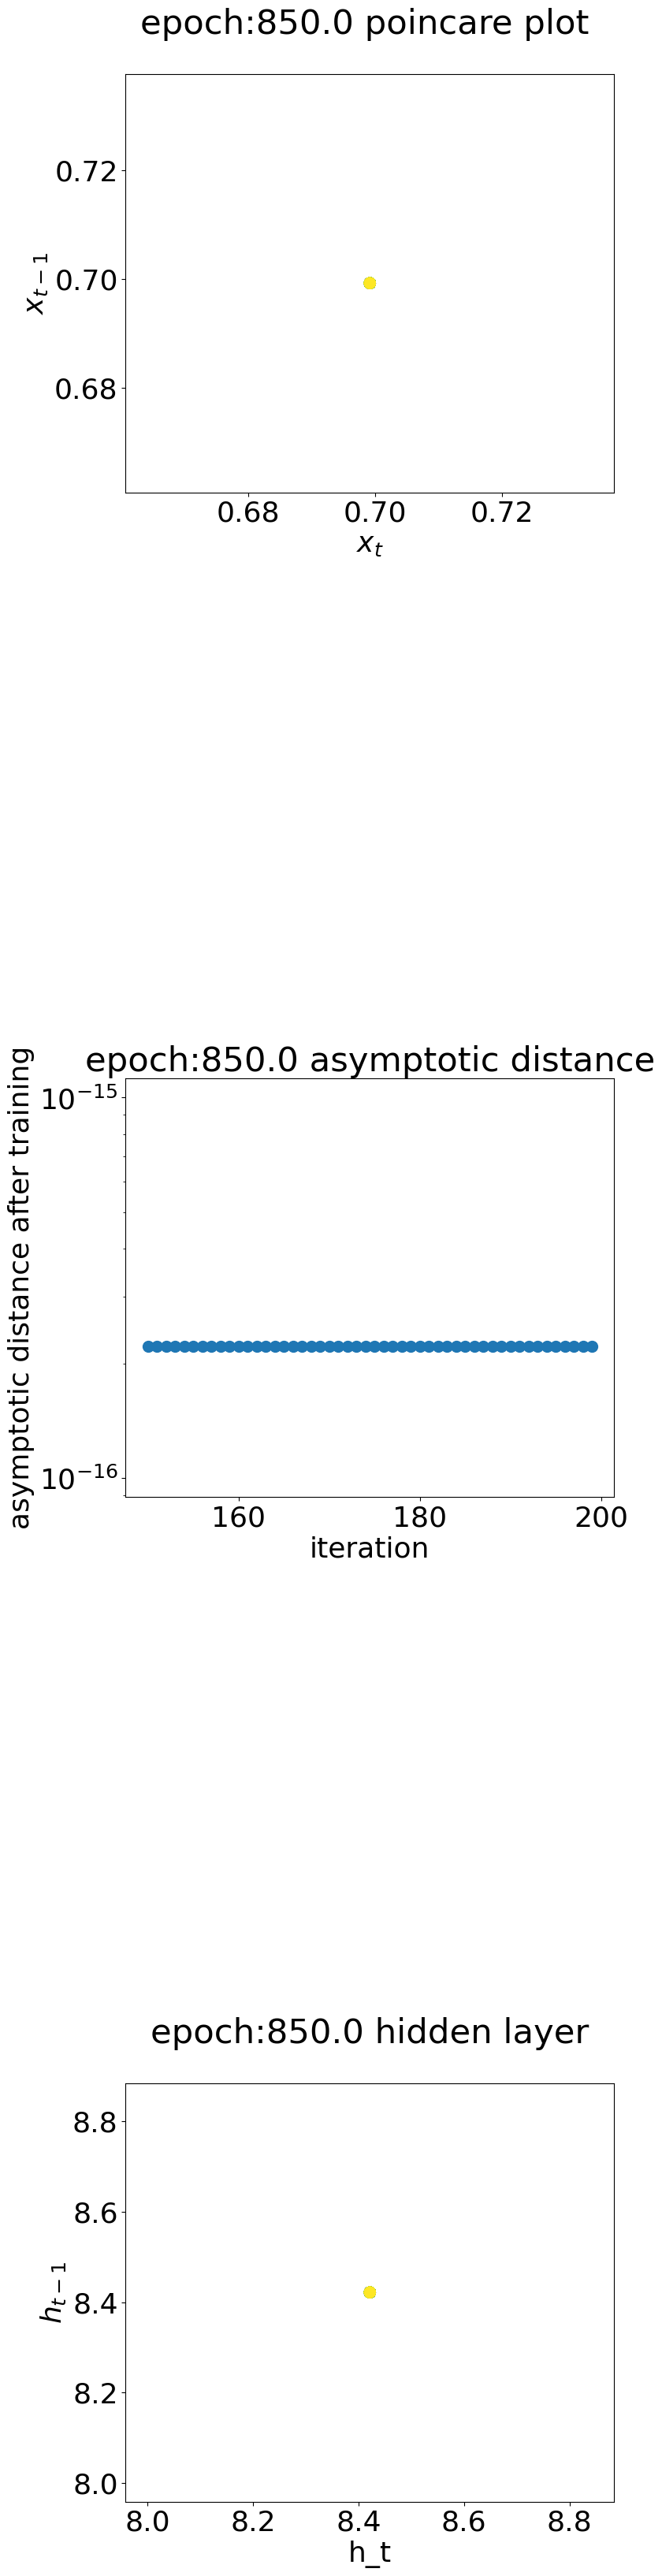

epoch : 851/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 852/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 853/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 854/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 855/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 856/1000, training loss = 0.375693,validation loss = 0.374298
epoch : 857/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 858/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 859/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 860/1000, training loss = 0.375693,validation loss = 0.374289
epoch : 861/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 862/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 863/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 864/1000, training loss = 0.375693,validation loss = 0.374299
epoch : 865/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.2505639   0.06588986  0.13235687 ... -0.0673757  -0.13536872
  -0.27588873]
 [-0.00852876 -0.01705877 -0.03412747 ... -0.01727585 -0.03456202
  -0.06920681]
 [-0.13908298 -0.28376504 -0.62236456 ...  0.00454166  0.00908351
   0.01816851]
 ...
 [ 0.04901871  0.09827412  0.19848399 ...  0.29941434 -0.00611266
  -0.01222577]
 [ 0.09918258  0.20035583  0.41822559 ...  0.26229915  0.56664283
   0.59913572]
 [ 0.83069681  0.63163778  0.94041444 ...  0.23125556  0.49028028
  -0.3018958 ]]
(tensor(-0.0017, grad_fn=<MeanBackward0>), tensor(0.2988, grad_fn=<VarBackward0>), tensor(0.0036, grad_fn=<MeanBackward0>), tensor(0.3295, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840d1f4ae0>
819541
40976.80000000005
[[-0.77928345  0.52265807 -1.1787536  ... -1.47193133 -0.11058871
   0.04395585]
 [ 0.08808222  0.17755281  0.3670635  ...  0.42930284 -1.0254259
  -0.11786959]
 [-0.23910846 -0.50918117 -0.0882094  ...  0.00229671  0.00459344
   0.00918707

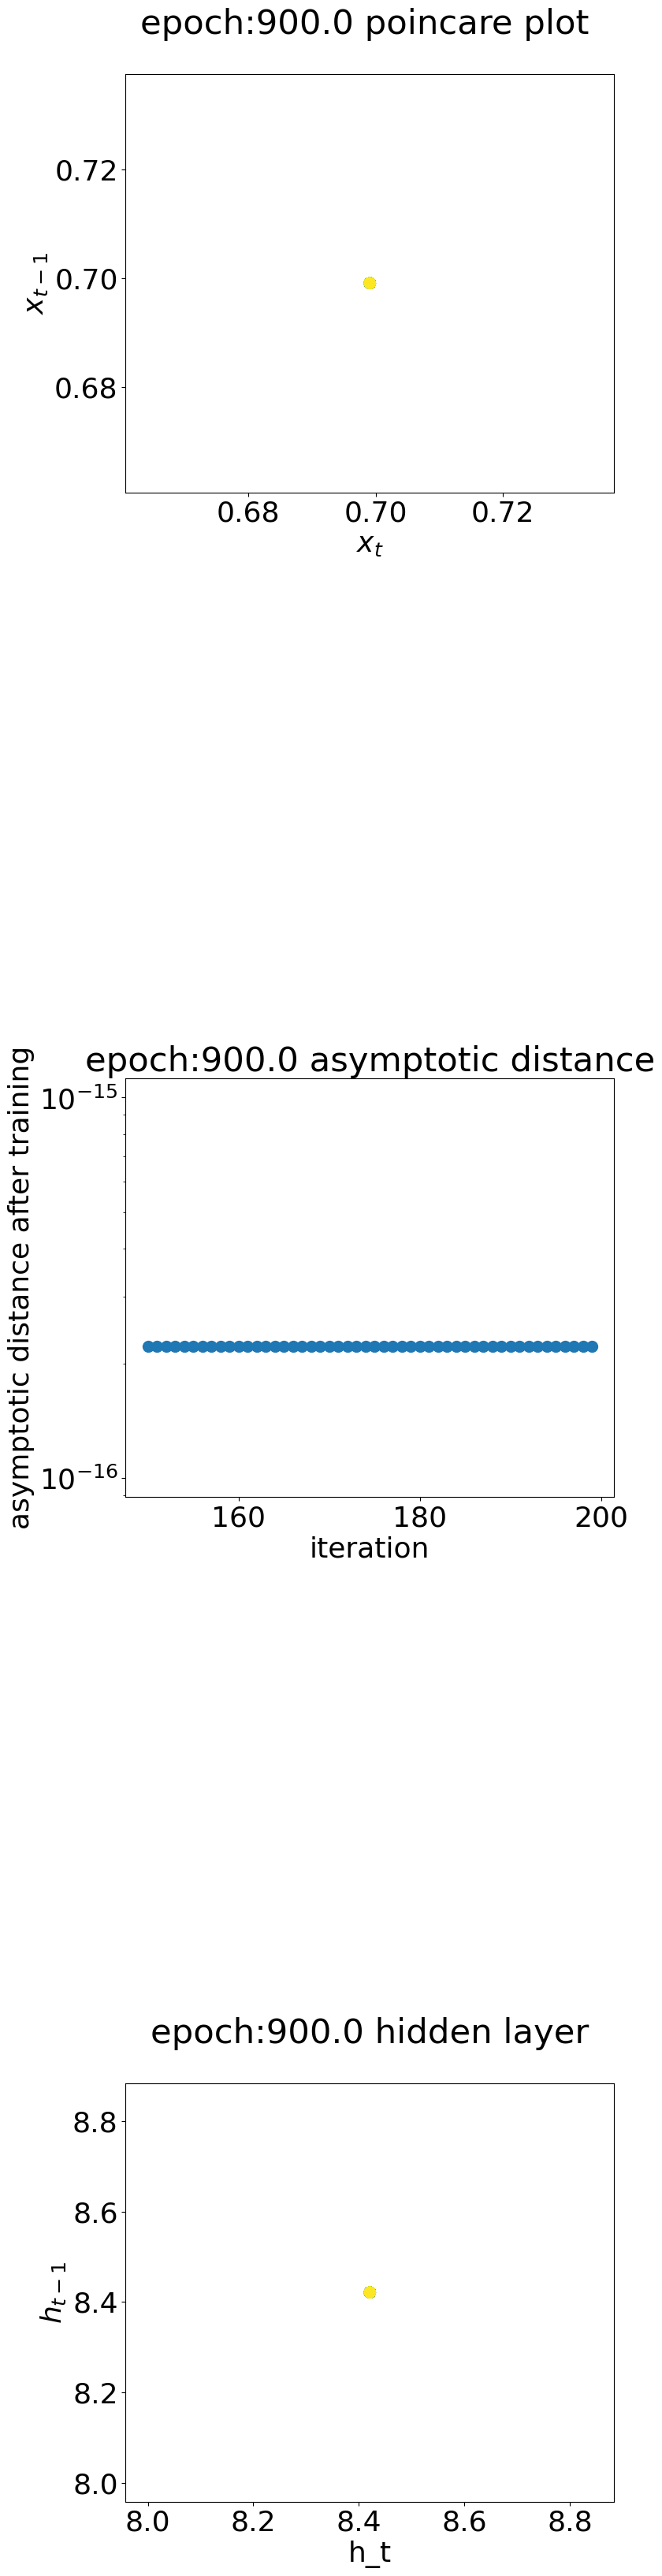

epoch : 901/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 902/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 903/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 904/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 905/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 906/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 907/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 908/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 909/1000, training loss = 0.375693,validation loss = 0.374304
epoch : 910/1000, training loss = 0.375693,validation loss = 0.374295
epoch : 911/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 912/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 913/1000, training loss = 0.375693,validation loss = 0.374294
epoch : 914/1000, training loss = 0.375693,validation loss = 0.374293
epoch : 915/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.03431619 -0.06871338 -0.13808183 ... -0.50399615 -0.14310977
  -0.29233384]
 [ 0.12600735  0.25614819  0.55114596 ... -0.92059631  0.75779678
   1.01946106]
 [-0.5730086   0.04700979  0.09422829 ... -0.24703852 -0.41354791
  -1.05297949]
 ...
 [ 0.48043016  0.81020197 -0.34182744 ...  0.03507836  0.07024325
   0.14118661]
 [ 0.28823751  0.63432572  0.0790681  ... -0.46053084 -0.14973678
  -0.30650615]
 [ 0.01781673  0.03564478  0.07138038 ... -0.19289612 -0.40131953
   0.61640388]]
(tensor(0.0010, grad_fn=<MeanBackward0>), tensor(0.2977, grad_fn=<VarBackward0>), tensor(-0.0036, grad_fn=<MeanBackward0>), tensor(0.3300, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f8401731b20>
819541
40976.80000000005
[[ 0.39965799  0.23527376  0.49991887 ... -0.47739484 -1.24064607
   0.26969465]
 [ 0.27673429  0.21922072  0.02570415 ... -0.06804061 -0.1367171
  -0.27874506]
 [-0.6090903  -0.6587147  -1.04074379 ... -0.06110307 -0.10846063
  -0.21953481

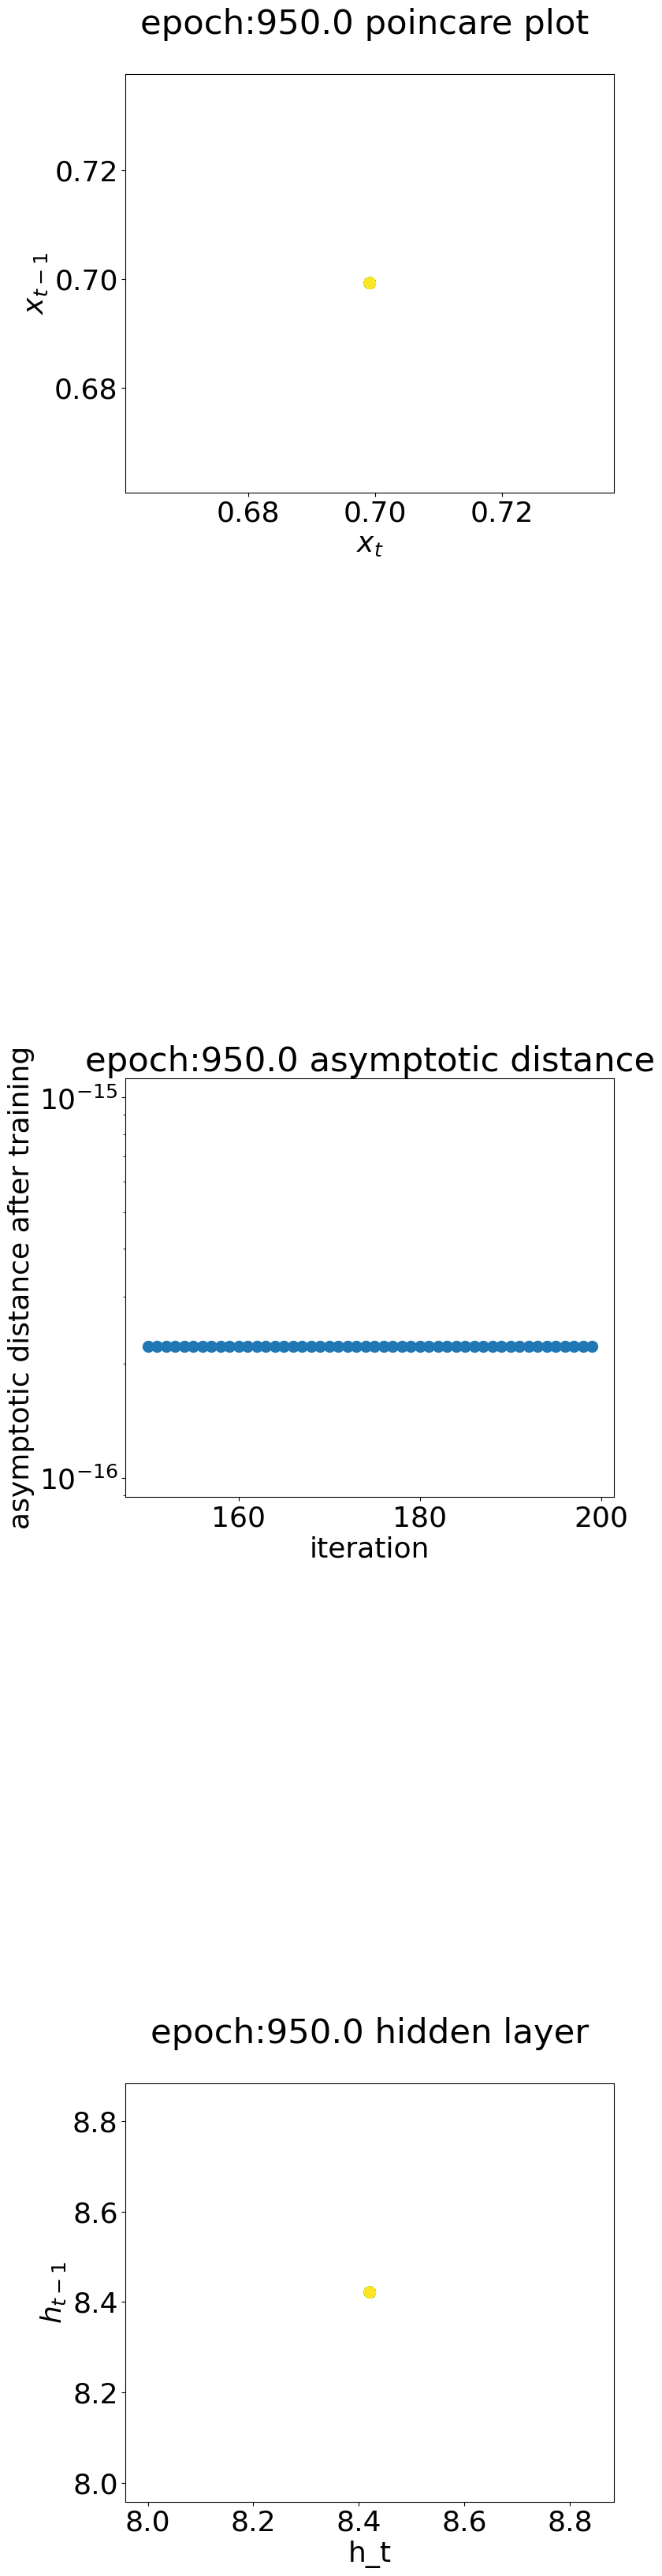

epoch : 951/1000, training loss = 0.375692,validation loss = 0.374292
epoch : 952/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 953/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 954/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 955/1000, training loss = 0.375693,validation loss = 0.374295
epoch : 956/1000, training loss = 0.375693,validation loss = 0.374297
epoch : 957/1000, training loss = 0.375693,validation loss = 0.374300
epoch : 958/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 959/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 960/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 961/1000, training loss = 0.375693,validation loss = 0.374291
epoch : 962/1000, training loss = 0.375693,validation loss = 0.374290
epoch : 963/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 964/1000, training loss = 0.375693,validation loss = 0.374292
epoch : 965/1000, tr

/tmp/ipykernel_9326/3645875348.py:25: RuntimeWarning: invalid value encountered in arctanh
  current=eta*np.arctanh((np.tanh(current))/delta)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_9326/3645875348.py:31: RuntimeWarning: overflow encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


40976.80000000005
[[-0.2730155  -0.59412667 -1.03389222 ... -0.11758806 -0.23852086
  -0.50775775]
 [-0.45703409 -0.30850504 -0.69026613 ...  1.18203814  0.1981571
   0.28663887]
 [ 0.63003544  0.95480083  0.49945452 ... -1.25806305  0.76714125
  -0.29571741]
 ...
 [ 0.57480352 -0.94530789 -0.11912243 ...  0.06703632  0.13468062
   0.27443238]
 [-0.22969425 -0.48655311  1.25889691 ... -0.30128124 -0.66998403
  -0.39433066]
 [-0.90299552  0.38640971  0.21553694 ... -0.09684902 -0.19554973
  -0.40731367]]
(tensor(0.0006, grad_fn=<MeanBackward0>), tensor(0.2989, grad_fn=<VarBackward0>), tensor(-0.0020, grad_fn=<MeanBackward0>), tensor(0.3306, grad_fn=<SubBackward0>))
<built-in method size of Parameter object at 0x7f840d1a9f30>
819541
40976.80000000005
[[ 0.68681218 -0.21177749  0.31785102 ... -0.36116309  0.47528567
  -0.78728315]
 [ 0.23120019 -0.17575453 -0.15993507 ... -0.4717379  -0.19765429
   0.34069235]
 [ 0.3287179  -0.32457006  0.15630901 ... -0.57695349  0.35704246
   0.04538319

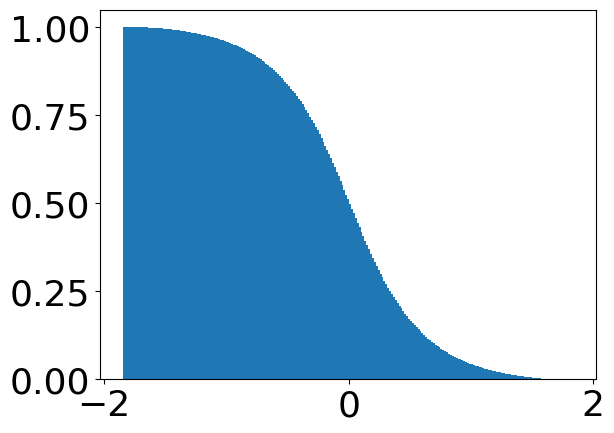

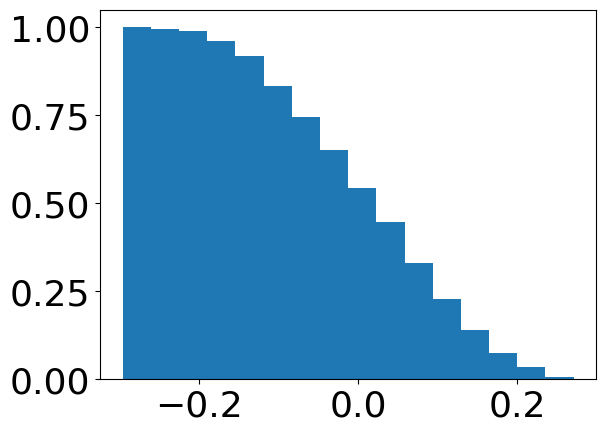

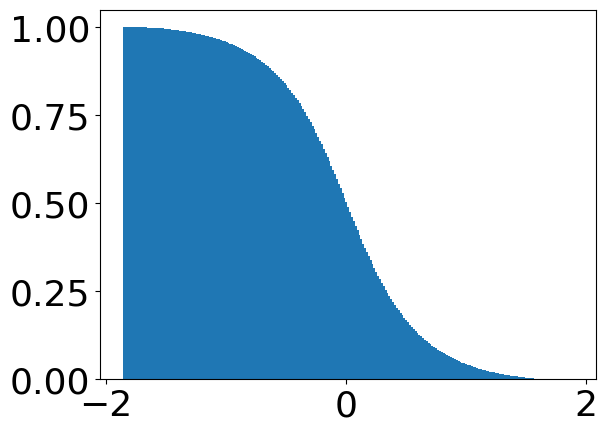

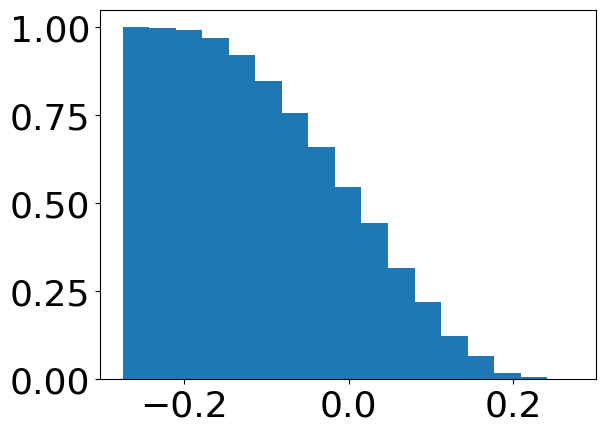

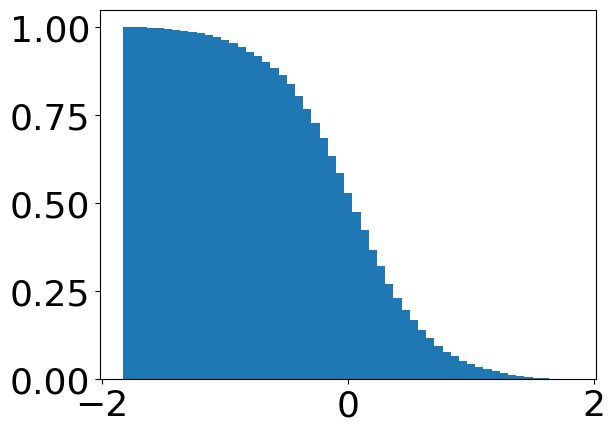

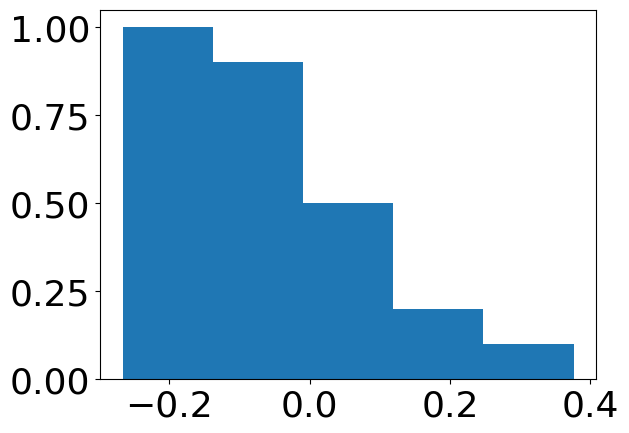

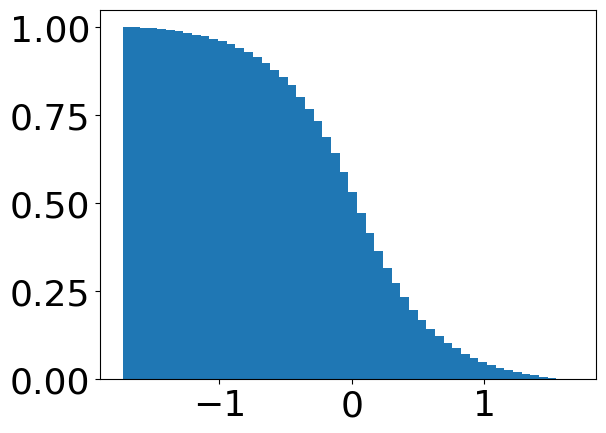

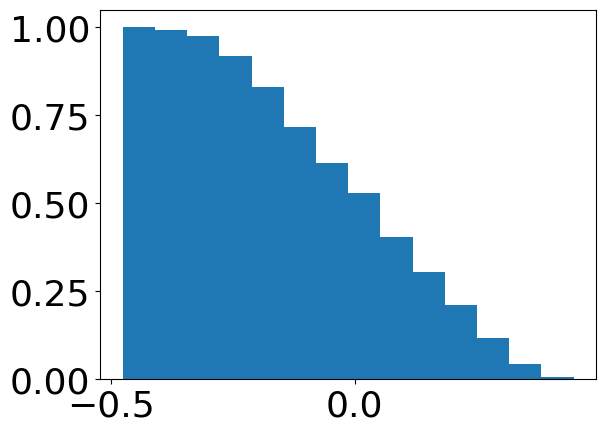

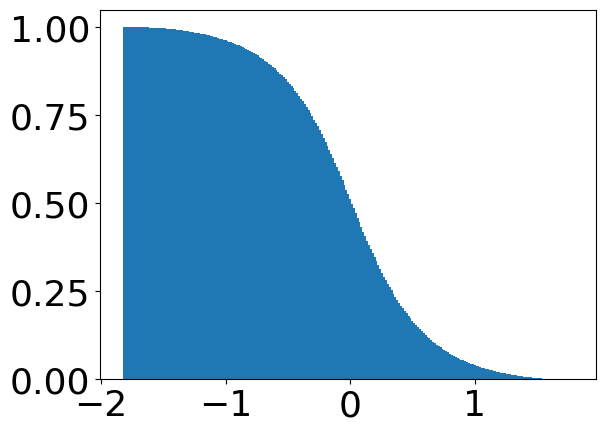

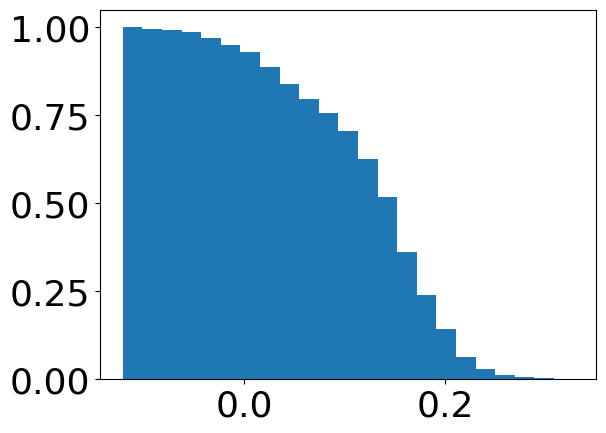

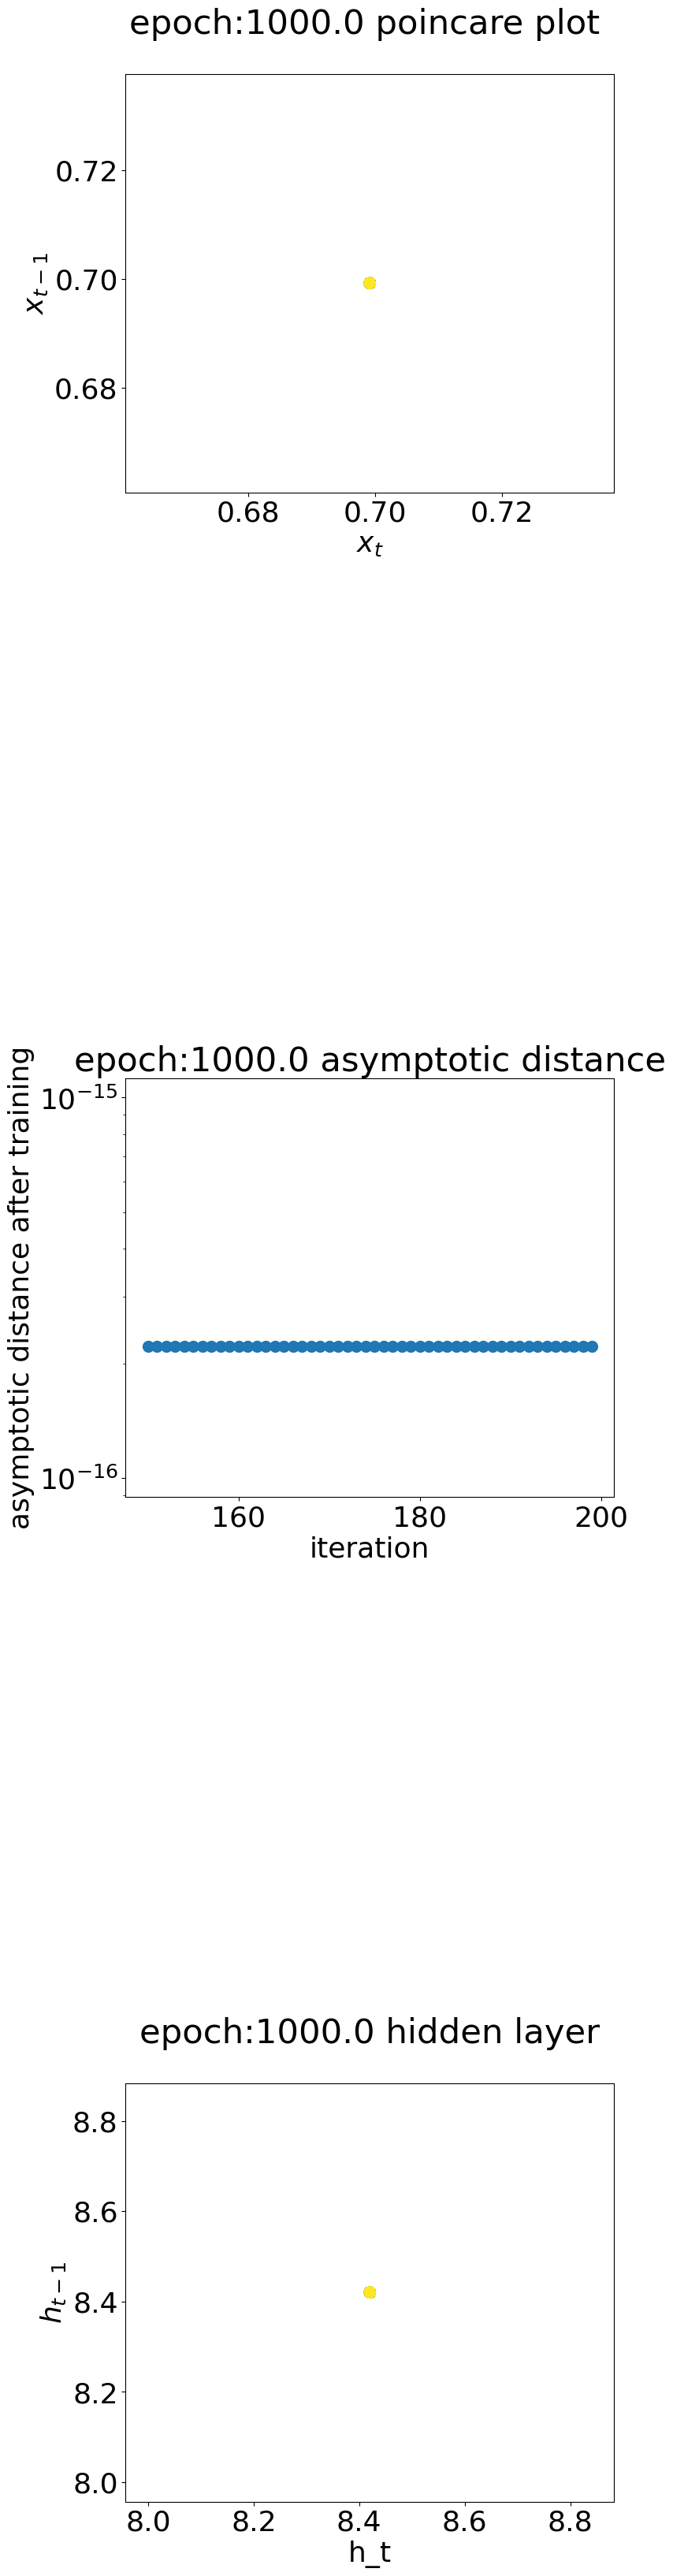

34006.06265544891
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:

spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
#diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=True
chao=[]
noise_print=False
for epoch in range(epochs):
    loss = 0


    for batch_features, _ in train_loader:
        # reshape mini-batch data to [1000, 784] matrix
        # load it to the active device
        input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        
        batch_feature=batch_features.view(batch_size,-1)
        #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,batch_feature.to(device))
        
        if init_compute==True and epoch%interval==0:
                #print("here")Trues 
                #print(train_loss)
            save_image=input_image
                #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
            perturbed_inputs=add_gaussian_noise(input_image,perturbation_strength)
                #print("perturbed_inputs")
                #print(torch.norm(perturbed_inputs))
            cutoff=[]
            for j in range(no_of_images):
                cutoff.append(torch.norm(perturbed_inputs[j]-input_image[j]))
            model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer)
            model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
            #model_clone.eval() 
            #print(cutoff)
            x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_inputs,epoch)
            x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
            #print("there")
            ##print(torch.norm(y_pred_perturbed))
            #print(torch.norm(y_pred_unperturbed))
            distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoff)
                
            asymptotic_dist.append(distance[-1])
            chao.append(chaos)
            
            plt.scatter(x=np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),y=distance,s=100)
            plt.xlabel("iteration")
            plt.ylabel("asymptotic distance")
            plt.yscale("log")
            plt.title("epoch:{:.1f} asymptotic distance before training".format(epoch))
            np.savetxt("asymptotic distance.txt"+str(epoch),distance)
            plt.savefig("initial asymptotic state.jpg")
            plt.show()
            #average_jacobian=[]
            #spectral_radiuses=[]
            init_compute=False
        # compute accumulated gradients
        train_loss.backward()

        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)

    
    with torch.no_grad():
        accuracy=validation(test_loader)
        validation_loss.append(accuracy)
        
        
    print("epoch : {}/{}, training loss = {:.6f},validation loss = {:.6f}".format(epoch+1 , epochs, loss,accuracy))
    if (epoch)%interval==interval-1:
        #dimension_vector=torch.ones(input_size).to(device)
        #xt,xtminus=poincare_plot(model_clone,x_train_unperturbed[0],dimension_vector,no_of_repetition,colour,epoch)
        #name="asymptotic image input"
#         #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
#         #x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
        perturbed_input=add_gaussian_noise(save_image,perturbation_strength)
        cutoffs=[]
        for j in range(no_of_images):
            cutoffs.append(torch.norm(perturbed_input[j]-save_image[j]))
        #print(cutoffs)
        x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_input,epoch)
        x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,save_image,epoch)
        distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoffs)
                

        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train_perturbed[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
         #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
     
       
         #perturbed_inputs=add_powerlaw_noise(input_size,batch_size,perturbation_strength,x_train.cpu()).view(batch_size, -1).to(device)
         #distance,hidden,chaos=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength)
        print("percentage of chaos:",chaos) 
        
        asymptotic_dist.append(distance[-1])
         #print(distance[-1])
        inits=0
        if epoch==epochs-1:
            for value in model.parameters():
                 #print(key)
                plots=torch.flatten(value).cpu().detach().numpy()
                plt.hist(plots, density=True, bins='auto', histtype='stepfilled',cumulative=-1)
                 #plt.title("model "+str(key)+"plot")
                plt.savefig("model "+str(inits)+"plot.jpg")
                np.savetxt("fianl weight"+str(inits)+".txt",value.cpu().detach().numpy())
                plt.show()
                inits+=1
        
        
        chao.append(chaos)
         #diverge.append(divergent/100)
        

        fig = plt.figure(figsize=(8,40))

        plt.subplot(5, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)
        #plt.xscale("log")
        #plt.yscale("log")
        
        plt.subplot(5, 1, 3)
        plt.scatter(np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance after training")
        np.savetxt("asymptotic distance"+str(epoch+1),distance)
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        
        
        plt.subplot(5, 1, 5)
        #plt.figure().set_figheight(8)
        plt.scatter(hidden[:-1],hidden[1:],c=colour[:-1],s=100)
        plt.xlabel("h_t")
        plt.ylabel("$h_{t-1}$")
        #plt.yscale("log")
        plt.title("epoch:{:.1f} hidden layer".format(epoch+1),y=1.08)
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+".jpg",bbox_inches = 'tight')
        plt.show()

        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)



[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
21
21


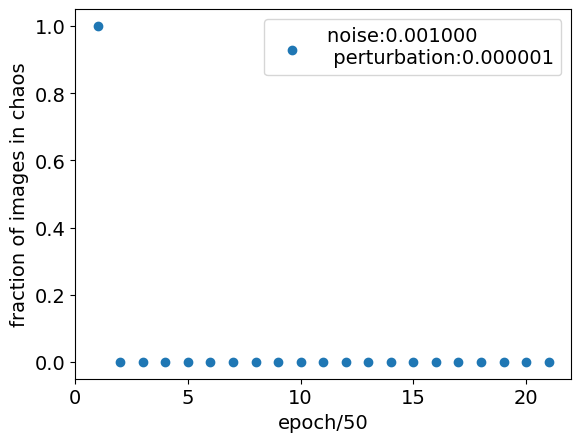

asymptotic distance


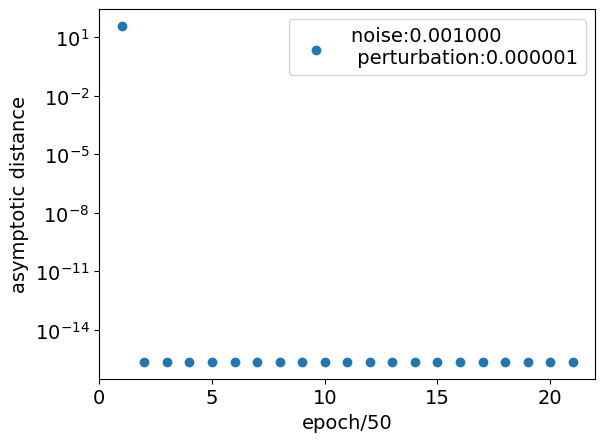

loss function


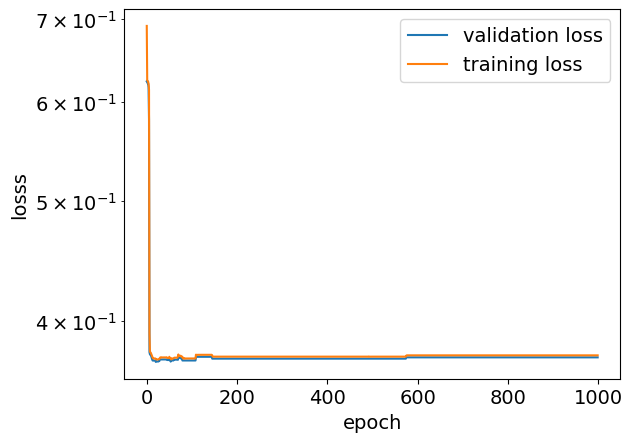

ValueError: x and y must be the same size

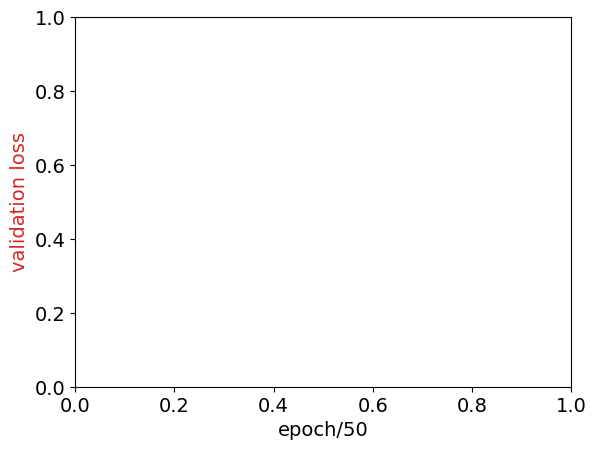

In [11]:
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)

print(chao)
font = {
        'size'   : 14}
plt.rc('font', **font)

intervals=50
x=np.arange(1,epochs/intervals+2)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao,label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/"+str(interval))
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("percentage of image in chaos.jpg")

np.savetxt("percentage of chaos.txt",chao)
plt.show()









print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg",)

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

#print("average jacobian")
#plt.scatter(x,y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("average jacobian")
#plt.xlabel("epoch/"+str(interval))
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("average_jacobian.jpg")
#np.savetxt("average jacobian.txt",average_jacobian)
#plt.show()

#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg")

np.savetxt("spectral radius.txt",spectral_radiuses)
plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg")
plt.show()
#print("asymptotic distance")
plot_loss=[]
for i in range(len(validation_loss)):
    if i%intervals==0:
        plot_loss.append(validation_loss[i])
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch/'+str(intervals))
ax1.set_ylabel('validation loss', color=color)
ax1.scatter(x,y=plot_loss, label="validation loss",color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('asymptotic distance', color=color)  # we already handled the x-label with ax1
ax2.scatter(x,y=asymptotic_dist, color=color,label="asymptotic distance")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.scatter(x,plot_loss,label="validation loss")
        
        
        
#plt.plot(x,plot_loss,label="validation loss")
plt.scatter(x,y=asymptotic_dist,label="asymptotic distance")

#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg")

plt.show()
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

plt.plot(validation_loss)
plt.yscale("log")
plt.show()

plt.plot(training_loss)
plt.yscale("log")
plt.show()